# Deep Learning Final Project
Spring 2024 -
Travis Mark, Brittany Laurent, Kai Mazurczyk

**[Part 1 - Where's Waldo Dataset
](https://colab.research.google.com/drive/1-5yRQHiAkxpk2xGmm6TNTwAgDr8kSwsp#scrollTo=EyoSFNS3-Nvk&line=5&uniqifier=1://)**

**[Part 2 - FINAL Wildfire Dataset](https://colab.research.google.com/drive/1-5yRQHiAkxpk2xGmm6TNTwAgDr8kSwsp#scrollTo=R6mrZmiU-bBG&line=1&uniqifier=1)**


In [1]:
%%capture
!pip install tensorflow-object-detection-api

In [2]:
%%capture
!pip install mahotas

In [3]:
%%capture
!pip install visualkeras

In [4]:
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import pandas as pd
import numpy as np

import argparse
import cv2
import glob
from io import StringIO
import os
from PIL import Image
import sys
import six.moves.urllib as urllib
import tarfile
import zipfile
from collections import defaultdict

import tensorflow as tf
import tensorflow.compat.v1 as tfs
from tensorflow.python.platform import gfile
from tensorflow.compat.v1 import GraphDef
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ReLU, Add, Input, BatchNormalization

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

import mahotas
import mahotas.demos
from pylab import imshow, show
import visualkeras

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

In [ ]:
MY_RANDOM_SEED = 123

In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Part 1 - Where's Waldo Dataset

The team first attempted an image classification project with <em> Where's Waldo </em> illustrations. What follows is exploratory data analysis and reference models based on this dataset, before finding the data too imbalanced to proceed.

We ultimately pivoted to a more balanced Wildfire dataset to complete the final deliverable. [For that, see Part 2.](https://colab.research.google.com/drive/1-5yRQHiAkxpk2xGmm6TNTwAgDr8kSwsp#scrollTo=R6mrZmiU-bBG&line=1&uniqifier=1)

# Load the Data with TensorFlow


The initial data set contained only 27 Waldo images, making our target class highly imbalanced and only representing 2.5% of the images. We performed augmentation on the Waldo images, by mirroring and rotating 90, 180, and 270 degrees, to produce 5 times as many Waldos. This provided us with our target class representing 12.9% of the images.

In [ ]:
#Prepare additional Waldo images using augmentation
#Image Directory
color128_folder='/content/gdrive/My Drive/WheresWaldo/128/waldo/'

#Load images from directory
def load_images_from_folder(folder):
    images = []
    for filename in folder:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

#Function to perform image augmentation (rotation and flipping)
def augment_data(images, output_folder, prefix):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for idx, img in enumerate(images):
        #Retain original image
        filename = os.path.join(output_folder, f"{prefix}_{idx}_original.jpg")
        cv2.imwrite(filename, img)

        #Rotate at 90, 180, 270 degrees
        for angle in [90, 180, 270]:
            rotated_img = np.rot90(img, k=(angle / 90))
            filename = os.path.join(output_folder, f"{prefix}_{idx}_rotated_{angle}.jpg")
            cv2.imwrite(filename, rotated_img)

        #Flip image
        flipped_img = np.fliplr(img)
        filename = os.path.join(output_folder, f"{prefix}_{idx}_flipped.jpg")
        cv2.imwrite(filename, flipped_img)

#Load images from the waldo class folder
waldo_images = load_images_from_folder(folder=color128_folder)

#Perform augmentation
augment_data(waldo_images, 'augmented_waldo_images', 'waldo')

In [ ]:
# NOTE: The Where's Waldo Directory must be in user's own Google Drive.

# To run with augmented images
#image_dir = '128-ed'
image_dir = '128-augmented'

# To run uned images
# image_dir = '128'

resolution = 128 # match to the source directory
data_path = f'/content/gdrive/My Drive/WheresWaldo/{image_dir}/'
NOTWALDODIR = 'notwaldo'
WALDODIR = 'waldo'

In [ ]:
# LOAD IMAGE DATASET
# randomized train/test split, class labeling, batching handled in single step
train_ds, test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_path,
    labels='inferred',
    class_names=['notwaldo','waldo'],
    validation_split=0.2,
    subset='both',
    seed=MY_RANDOM_SEED,
    shuffle=True,
    color_mode='rgb',
    image_size=(resolution,resolution)
)

Found 1522 files belonging to 2 classes.
Using 1218 files for training.
Using 304 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
print("num batches",tf.data.experimental.cardinality(train_ds))
for images, classes in train_ds.take(1):
  print("X shape",images.shape)
  print("y shape",classes.shape)

num batches tf.Tensor(39, shape=(), dtype=int64)
X shape (32, 128, 128, 3)
y shape (32,)


# Explore the Training Data

We explore the distributions of the Waldo/not Waldo classes to infer any problems or interesting trends in the distribution.

In [ ]:
# unbatch and load to NP so we can get some useful aggregate stats
(train_images,train_labels) = tuple(zip(*train_ds.take(-1)))
train_images = np.concatenate(train_images, axis = 0)/255 # go ahead and scale the data for plt
train_labels = np.concatenate(train_labels, axis = 0)

In [ ]:
# Split the Training Data into Waldo and Not-Waldo data, for any trends we can infer
filt = np.where(train_labels == 1)
waldo_images = train_images[filt]
waldo_labels = train_labels[filt]

not_waldo_images = np.delete(train_images, filt, axis = 0)
not_waldo_labels = np.delete(train_labels, filt, axis = 0)


### X Variable: Image Data - Summary Statistics
* Our inputs are image data, arrays of 128x128x3 with continuous values, representing RGB pixel values.
* Note values are scaled to range(0,1).

In [ ]:
def np_describe(image_data):
  means = [round(np.mean(image_data[:,:,:,i]),3) for i in range(3)]
  sd = [round(np.sqrt(np.var(image_data[:,:,:,i])),3) for i in range(3)]
  mins = [np.min(image_data[:,:,:,i]) for i in range(3)]
  maxs = [np.max(image_data[:,:,:,i]) for i in range(3)]
  n = image_data.shape[0]

  return means, sd, mins, maxs, n

summary_statistics = {'train_summary':np_describe(train_images), \
                      'waldo_summary':np_describe(waldo_images), \
                      'not_waldo_summary':np_describe(not_waldo_images) \
                      }

for k, v in summary_statistics.items():
    print(f"RGB Color Channels: {k} \n\n Means  {v[0]}, \n SD     {v[1]}, \n Mins   {v[2]}, \n Maxs   {v[3]} \n n samples {v[4]} \n")


RGB Color Channels: train_summary 

 Means  [0.632, 0.584, 0.486], 
 SD     [0.282, 0.29, 0.291], 
 Mins   [0.0, 0.0, 0.0], 
 Maxs   [1.0, 1.0, 1.0] 
 n samples 1218 

RGB Color Channels: waldo_summary 

 Means  [0.649, 0.584, 0.478], 
 SD     [0.273, 0.29, 0.292], 
 Mins   [0.0, 0.0, 0.0], 
 Maxs   [1.0, 1.0, 1.0] 
 n samples 157 

RGB Color Channels: not_waldo_summary 

 Means  [0.63, 0.583, 0.487], 
 SD     [0.283, 0.29, 0.291], 
 Mins   [0.0, 0.0, 0.0], 
 Maxs   [1.0, 1.0, 1.0] 
 n samples 1061 




All the channels have similar centers, variance and scale.

### Y Variable: Waldo Classification - Summary Statistics

* Our output is a binary classification:
  * 0: not waldo
  * 1: waldo

* We discovered the data are highly imbalanced - our Waldo class of interest is less than 1% of the dataset without augmentation and about 12% with augmentation. This could impact our models' performance.

In [ ]:
labels, counts = np.unique(train_labels, return_counts = True)
print(f"Training Pct of Data with Waldo: {round(np.mean(train_labels)*100,3)}% \nlabels {labels}, counts {counts}")

Training Pct of Data with Waldo: 12.89% 
labels [0 1], counts [1061  157]


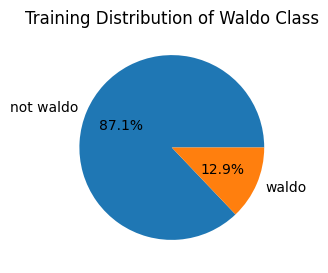

In [ ]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.title('Training Distribution of Waldo Class')
plt.pie(counts, labels = ['not waldo','waldo'],autopct = '%1.1f%%')
plt.show()

### Examine any trends in the images, Waldo vs Not Waldo

Beyond knowing Waldo is labeled in one data set, and not the other, are there any other biases or patterns in the image that would indicate the Waldo class? We compared the channel distributions between Waldos and Not Waldos for any interesting differences.

<b> Histogram</b>

Here we compare the color distributions between Waldos and Not Waldos.

Mindful the Waldo class is much smaller, the distributions are nearly identical. Nothing to see here.

Text(0, 0.5, 'Frequency')

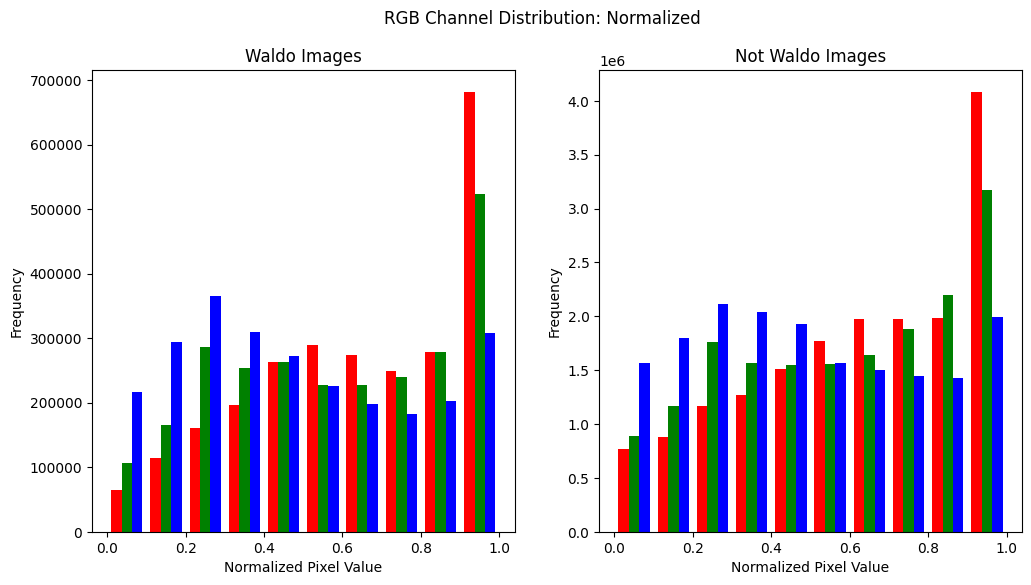

In [ ]:
%matplotlib inline

fig, (ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(12,6))
fig.suptitle('RGB Channel Distribution: Normalized')
colors = ['red','green','blue']
n,x,y,c = waldo_images.shape
ax1.hist(waldo_images.reshape((n*x*y),c), color=colors, label=colors)
ax1.set_title('Waldo Images')
ax1.set_xlabel('Normalized Pixel Value')
ax1.set_ylabel('Frequency')

n,x,y,c = not_waldo_images.shape
ax2.hist(not_waldo_images.reshape((n*x*y),c), color=colors, label=colors)
ax2.set_title('Not Waldo Images')
ax2.set_xlabel('Normalized Pixel Value')
ax2.set_ylabel('Frequency')

# Data Cleansing - Annotation

Since we had very imbalanced data and initially struggled with poorly performing models, we experimented with shifting the problem itself toward object detection. Maybe classification performs better if we could put bounding boxes over the object of interest (Waldo)?

The following code worked well to annotate Waldo when his signature striped shirt clearly appeared in the image, but when he was cropped or obscured by another character, annotation didn't work.

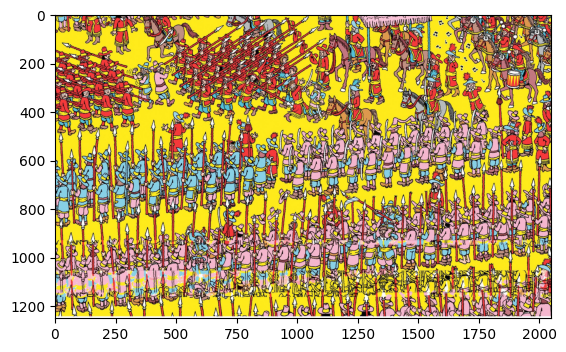

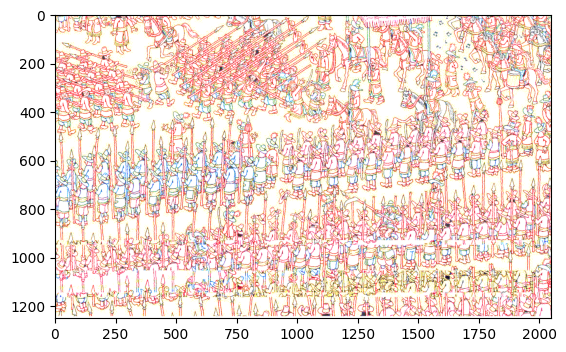

In [ ]:

wally = Image.open('/content/gdrive/My Drive/WheresWaldo/1.jpg')
imshow(wally)
show()

wally = np.asarray(wally)
wfloat = wally.astype(float)
r,g,b = wfloat.transpose((2,0,1))

w = wfloat.mean(2)

pattern = np.ones((24,16), float)
for i in range(2):
    pattern[i::4] = -1

v = mahotas.convolve(r-w, pattern)

mask = (v == v.max())
mask = mahotas.dilate(mask, np.ones((48,24)))

wally = wally.astype(np.float64)
wally -= .8*wally * (~mask[:,:,None]).astype(np.uint8)

wfloat = wally.astype(float)
r,g,b = wfloat.transpose((2,0,1))
w = wfloat.mean(2)
pattern = np.ones((24,16), float)
for i in range(2):
    pattern[i::4] = -1
v = mahotas.convolve(r-w, pattern)
mask = (v == v.max())
mask = mahotas.dilate(mask, np.ones((48,24)))
np.subtract(wally, .8*wally * ~mask[:,:,None], out=wally, casting='unsafe')
imshow(wally)
show()

In [ ]:
# #IMAGE where you want to find waldo
# img_rgb = cv2.imread('/content/gdrive/My Drive/WheresWaldo/2.jpg')

# img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
# # a generic formatted picture of waldo
# template = cv2.imread('/content/gdrive/My Drive/WheresWaldo/waldo.jpg',0)

# # saves the width and height of the template into 'w' and 'h'

# w, h = template.shape[::-1]
# res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)

# threshold = 0.6
# # finding the values where it exceeds the threshold
# loc = np.where( res >= threshold)
# for pt in zip(*loc[::-1]):
#     #draw rectangle on places where it exceeds threshold
#     cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,255,0), 2)
# cv2.imwrite('found_waldo.png',img_rgb)

# Reference Models - Machine Learning Methods

First, we must see if our image classification problem can be achieved with simpler machine learning methods.

## A Simple Approach
The full Where's Waldo images are broken down into smaller images arranged in a grid to cover the full sized image. These smaller images are accordingly named based on their position on this grid. Here we will utilize this naming convention to plot the waldo and non-waldo images as x,y coordinates. Then use a KMeans and K-Nearest Neighbor to predict if images contain Waldo.  
Next, we will also utilize the gray scale version of these images and flatten them into arrays. With this gray scale data, we will utilize a Gradient Boost classifier to attempt to determine which images contain Waldo.

In [ ]:
#Function to split the image file names into components of image number, x-coord, y-coord
def split_filename(filename):
    components = filename.split('_')
    name=components[0]
    x=int(components[1])
    #The numbering system starts in the top left. Add negative sign to y component to format in standard cartesian coordiantes
    y=-int(components[2].split(' ')[0].split('.')[0])
    return name, x, y

In [ ]:
#Function to process all the file names in a folder and return a list with associated components
def process_files(directory, label):
    file_names=os.listdir(directory)
    data=[]
    for file_name in file_names:
        if file_name.endswith('.jpg'):
            name,x,y=split_filename(file_name)
            data.append({'name':name, 'x':x, 'y':y, 'label':label})
    return data

In [ ]:
#Process the waldo images and build a data frame
waldos_df = pd.DataFrame(process_files('/content/gdrive/My Drive/WheresWaldo/64/waldo/',1))
print(waldos_df)

   name   x   y  label
0    14   1 -12      1
1    13   1  -1      1
2    12   3 -12      1
3    17  13  -5      1
4     4   2 -12      1
5    19   0  -7      1
6    10  15  -4      1
7    18  14  -7      1
8    12   2  -2      1
9    12   2  -1      1
10    7  12  -5      1
11    9   0 -11      1
12   13   2 -11      1
13   19   0  -6      1
14    1   4  -6      1
15   11   6 -11      1
16    2   2  -5      1
17    9   1 -12      1
18    3  15  -1      1
19    4   2 -11      1
20   18  14  -6      1
21   16  10  -4      1
22    9   9  -5      1
23   18  15  -7      1
24    9   0 -10      1
25    2   7  -3      1
26   13   6  -3      1
27    5   2  -5      1
28   13   5  -2      1
29   13   5  -3      1
30    6  15  -1      1
31    9   5  -5      1
32   18   2 -15      1
33    5   7  -3      1
34    9   0 -12      1
35   18   2 -14      1
36    1   4  -7      1
37   13   6  -2      1
38   18  15  -6      1


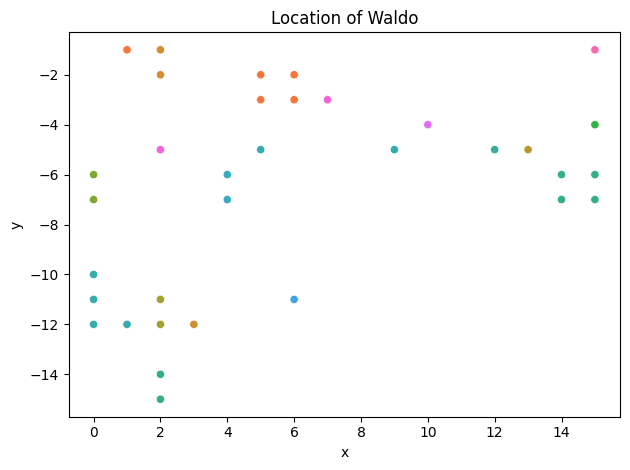

In [ ]:
sns.scatterplot(data=waldos_df,x='x',y='y', hue='name',legend=None)
plt.title('Location of Waldo')
plt.tight_layout()
plt.show()

In [ ]:
#Process non-waldo images and create a combined data frame
non_df = pd.DataFrame(process_files('/content/gdrive/My Drive/WheresWaldo/64/notwaldo/',0))
df=pd.concat([waldos_df,non_df], axis=0)

### KMeans

In [ ]:
#For distance based metrics, scale the data
scaler=MinMaxScaler()
df_scaled=pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
df_scaled

name         x         y  label
0     0.65  0.066667  0.200000    1.0
1     0.60  0.066667  0.933333    1.0
2     0.55  0.200000  0.200000    1.0
3     0.80  0.866667  0.666667    1.0
4     0.15  0.133333  0.200000    1.0
...    ...       ...       ...    ...
5371  1.00  0.400000  0.933333    0.0
5372  0.10  0.133333  0.333333    0.0
5373  0.75  0.800000  0.200000    0.0
5374  0.10  0.266667  0.066667    0.0
5375  0.55  0.266667  0.066667    0.0

[5376 rows x 4 columns]

In [ ]:
X=df.drop(columns=['label']).copy()
y=df['label']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.3, random_state=36)

In [ ]:
#Check for distribution of labels in both sets
y_test.sum()/y_train.sum()

0.4444444444444444

In [ ]:
#Fit a KMeans model
km=KMeans(n_clusters=2, n_init=10, random_state=1506)
km.fit(X_train[['x','y']])

KMeans(n_clusters=2, n_init=10, random_state=1506)

In [ ]:
#Generate predictions on test images, using the x,y coordinates
km_preds=km.predict(X_test[['x','y']])
labels=pd.DataFrame(y_test)
labels['km_label']=km_preds

In [ ]:
#Records metrics of the KMeans predictions
scores=np.array([[accuracy_score(y_test,km_preds), precision_score(y_test,km_preds), recall_score(y_test,km_preds), f1_score(y_test,km_preds)]])
#Create a confusion matrix
cm=confusion_matrix(y_test,km_preds)
print(cm)
print(f'Accuracy of the KMeans model is: {round(scores[0][0],4)}')
print(f'Precision of the KMeans model is: {round(scores[0][1],4)}')
print(f'Recall of the KMeans model is: {round(scores[0][2],4)}')
print(f'F1 score of the KMeans model is: {round(scores[0][3],4)}')

[[815 786]
 [  2  10]]
Accuracy of the KMeans model is: 0.5115
Precision of the KMeans model is: 0.0126
Recall of the KMeans model is: 0.8333
F1 score of the KMeans model is: 0.0248


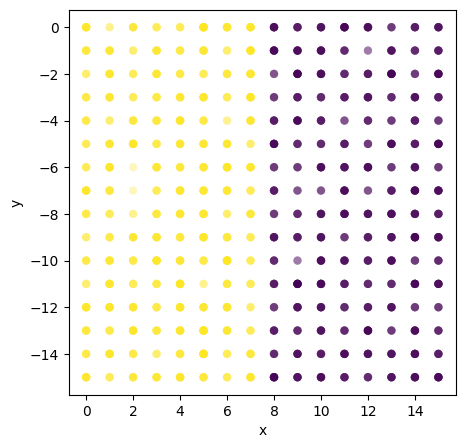

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=X_test.x, y=X_test.y, c= km_preds, alpha= 0.3, ax= ax, edgecolor= 'none')
plt.show()

#### KMeans Results
The KMeans clustering was able to successfully identify 9 of the 12 waldo images, 75%. However, this was accomplished with a scatter shot approach which produced 807 false positives, resulting in a precision score of only 0.01. Which means the images the model identifies as containing Waldo are incorrect 99% of the time. The graph shows that the KMeans is not an effective approach to classify the images as waldo or not waldo, the algorithm simply splits the sample in half horizontally.  
With the imbalanced nature of our data, the primary metric we will use to compare models is the F1-Score. The F1-Score of the KMeans model is 0.02. Considering the established goal of identifying Waldo quickly, the KMeans model is not useful.

### K-Nearest Neighbors

In [ ]:
#Fit a K Nearest Neighbors model with single nearest point
knn=KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train[['x','y']],y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
#Generate predictions on test images
knn_preds=knn.predict(X_test[['x','y']])

In [ ]:
#Records metrics of the KNN predictions
scores=np.append(scores,[[accuracy_score(y_test,knn_preds), precision_score(y_test,knn_preds), recall_score(y_test,knn_preds), f1_score(y_test,knn_preds)]], axis=0)
#Create a confusion matrix
cm=confusion_matrix(y_test,knn_preds)
print(cm)
print(f'Accuracy of the KNN model is: {round(scores[1][0],4)}')
print(f'Precision of the KNN model is: {round(scores[1][1],4)}')
print(f'Recall of the KNN model is: {round(scores[1][2],4)}')
print(f'F1 score of the KNN model is: {round(scores[1][3],4)}')

[[1601    0]
 [  12    0]]
Accuracy of the KNN model is: 0.9926
Precision of the KNN model is: 0.0
Recall of the KNN model is: 0.0
F1 score of the KNN model is: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


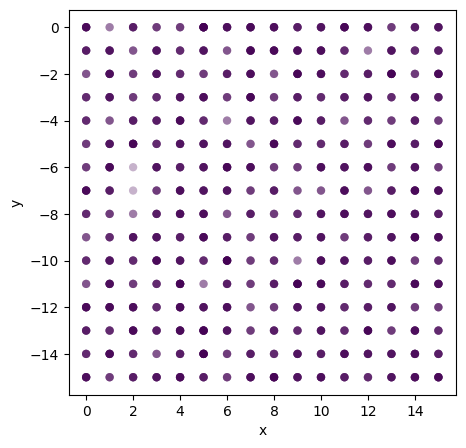

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=X_test.x, y=X_test.y, c= knn_preds, alpha= 0.3, ax= ax, edgecolor= 'none')
plt.show()

#### KNN Results
The KNN model was not able to successfully identify any of the 12 waldo images in the test set. On the positive side, KNN reduced the number of false positives. However, this was accomplished by essentially labeling nearly all images as not Waldo, achieving 99% accuracy.
The F1-Score of the KNN model is 0.0. The KNN model is completely ineffective.

### XGBoost
Here, we will use the grey scale images and flatten them into an array. Using this data set we will implement a Gradient Boost calssifier to identify the waldo images.

In [ ]:
#Load flattened gray scale images data
flat_waldo=pd.read_csv('/content/gdrive/My Drive/WheresWaldo/Waldo64gray.csv', header=None)
flat_non=pd.read_csv('/content/gdrive/My Drive/WheresWaldo/NotWaldo64gray.csv', header=None)
flat_df=pd.concat([flat_waldo,flat_non],axis=0, ignore_index=True)
#Create X & y sets
flat_X=flat_df.copy().drop(columns=[4096])
flat_y=flat_df[4096]
#Split into train and test
flat_X_train, flat_X_test, flat_y_train, flat_y_test=train_test_split(flat_X, flat_y, train_size=.7, random_state=1506)

In [ ]:
#Fit an XGBoost classifier
xgb=GradientBoostingClassifier(max_features='log2', random_state=36)
xgb.fit(flat_X_train, flat_y_train)

GradientBoostingClassifier(max_features='log2', random_state=36)

In [ ]:
#Make preditcions on the test images
xgb_preds=xgb.predict(flat_X_test)

In [ ]:
#Records metrics of the XGBoost predictions
scores=np.append(scores,[[accuracy_score(flat_y_test,xgb_preds), precision_score(flat_y_test,xgb_preds), recall_score(flat_y_test,xgb_preds), f1_score(flat_y_test,xgb_preds)]], axis=0)
#Create a confusion matrix
cmxgb=confusion_matrix(flat_y_test,xgb_preds)
print(cmxgb)
print(f'Accuracy of the XGBoost model is: {round(scores[2][0],4)}')
print(f'Precision of the XGBoost model is: {round(scores[2][1],4)}')
print(f'Recall of the XGBoost model is: {round(scores[2][2],4)}')
print(f'F1 score of the XGBoost model is: {round(scores[2][3],4)}')

[[1603    0]
 [   9    1]]
Accuracy of the XGBoost model is: 0.9944
Precision of the XGBoost model is: 1.0
Recall of the XGBoost model is: 0.1
F1 score of the XGBoost model is: 0.1818


#### XGBoost Results
The XGboost model was only able to correctly identify 1 of the 10 waldo images in the test data. The model only predicted 1 waldo image, so there were no false positives. The F1-Score of the XGBoost model is 0.18. Overall, the XGBoost model was ineffective in identifying waldo images.

# Reference Models - ResNet

Since machine learning methods did not perform well for our problem, we turned to deep learning methods.

ResNet is known to be highly accurate but it's also maximally complex. We hoped this model would work well because our ultimate goal would be to achieve a similar accuracy with a simpler model.

Model Reference https://keras.io/api/applications/resnet/

Steps largely adapted from https://www.tensorflow.org/tutorials/images/transfer_learning

#### Frozen Base Model

In [ ]:
# INSTANTIATE BASE MODEL
base_model = ResNet50(
    weights = 'imagenet',
    classes = 1,
    input_shape = (resolution, resolution, 3),
    include_top = False, # we will keep the convolution layers but add our own waldo classifier
    )

# FREEZE BASE MODEL
base_model.trainable = False

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

#### Trainable Classifying and Predicting Layers

In [ ]:
# DEFINE OUR OWN WALDO CLASSIFICATION LAYERS

# WALDO CLASSIFICATION
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# WALDO PREDICTION
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid') # binary class

In [ ]:
# Confirm the appropriate shapes at each step

# CONVOLUTION OUTPUT
images, classes = next(iter(train_ds))
features = base_model(images)
print(features.shape)

# CLASSIFICATION LAYER
feature_batch_average = global_average_layer(features)
print(feature_batch_average.shape)

# PREDICTION LAYER
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4, 4, 2048)
(32, 2048)
(32, 1)


#### Model End to End

In [ ]:
# OUR REFERENCE MODEL - END-TO-END
inputs = tf.keras.Input(shape=(resolution, resolution, 3))
x = inputs
# x = data_augmentation(inputs) # ALREADY ADDED AUGMENTED FILES TO DATA
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.30)(x) # removed - this did not help
outputs = prediction_layer(x)
resnet_reference_model = tf.keras.Model(inputs, outputs)

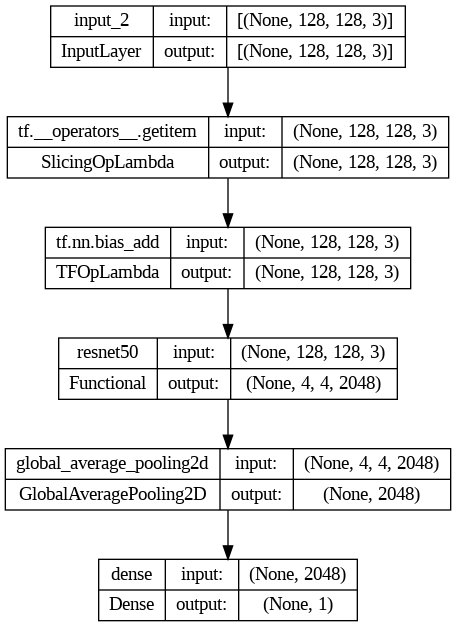

In [ ]:
# # resnet_reference_model.summary()
tf.keras.utils.plot_model(resnet_reference_model, show_shapes=True)

#### Train Top Layers

In [ ]:
# COMPILE - starting out with Keras suggested config
metrics = [tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),
           tf.keras.metrics.TruePositives(name='tp'),
           tf.keras.metrics.FalsePositives(name='fp'),
           tf.keras.metrics.TrueNegatives(name='tn'),
           tf.keras.metrics.FalseNegatives(name='fn'),
           tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')
          ]

base_learning_rate = 0.0001 #0.0005
resnet_reference_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=metrics)

In [ ]:
# TRAIN
initial_epochs = 100

history = resnet_reference_model.fit(
                    train_ds,
                    validation_data=test_ds,
                    epochs = initial_epochs
                    )
history

Epoch 1/100
39/39 [==============================] - 145s 3s/step - loss: 0.5125 - cross entropy: 0.5125 - tp: 11.0000 - fp: 104.0000 - tn: 957.0000 - fn: 146.0000 - accuracy: 0.7947 - precision: 0.0957 - recall: 0.0701 - auc: 0.4968 - val_loss: 0.4089 - val_cross entropy: 0.4089 - val_tp: 2.0000 - val_fp: 5.0000 - val_tn: 261.0000 - val_fn: 36.0000 - val_accuracy: 0.8651 - val_precision: 0.2857 - val_recall: 0.0526 - val_auc: 0.6159
Epoch 2/100
39/39 [==============================] - 137s 3s/step - loss: 0.4237 - cross entropy: 0.4237 - tp: 1.0000 - fp: 15.0000 - tn: 1046.0000 - fn: 156.0000 - accuracy: 0.8596 - precision: 0.0625 - recall: 0.0064 - auc: 0.5627 - val_loss: 0.3807 - val_cross entropy: 0.3807 - val_tp: 2.0000 - val_fp: 5.0000 - val_tn: 261.0000 - val_fn: 36.0000 - val_accuracy: 0.8651 - val_precision: 0.2857 - val_recall: 0.0526 - val_auc: 0.6626
Epoch 3/100
39/39 [==============================] - 101s 3s/step - loss: 0.3896 - cross entropy: 0.3896 - tp: 6.0000 - fp: 1

#### Evaluate

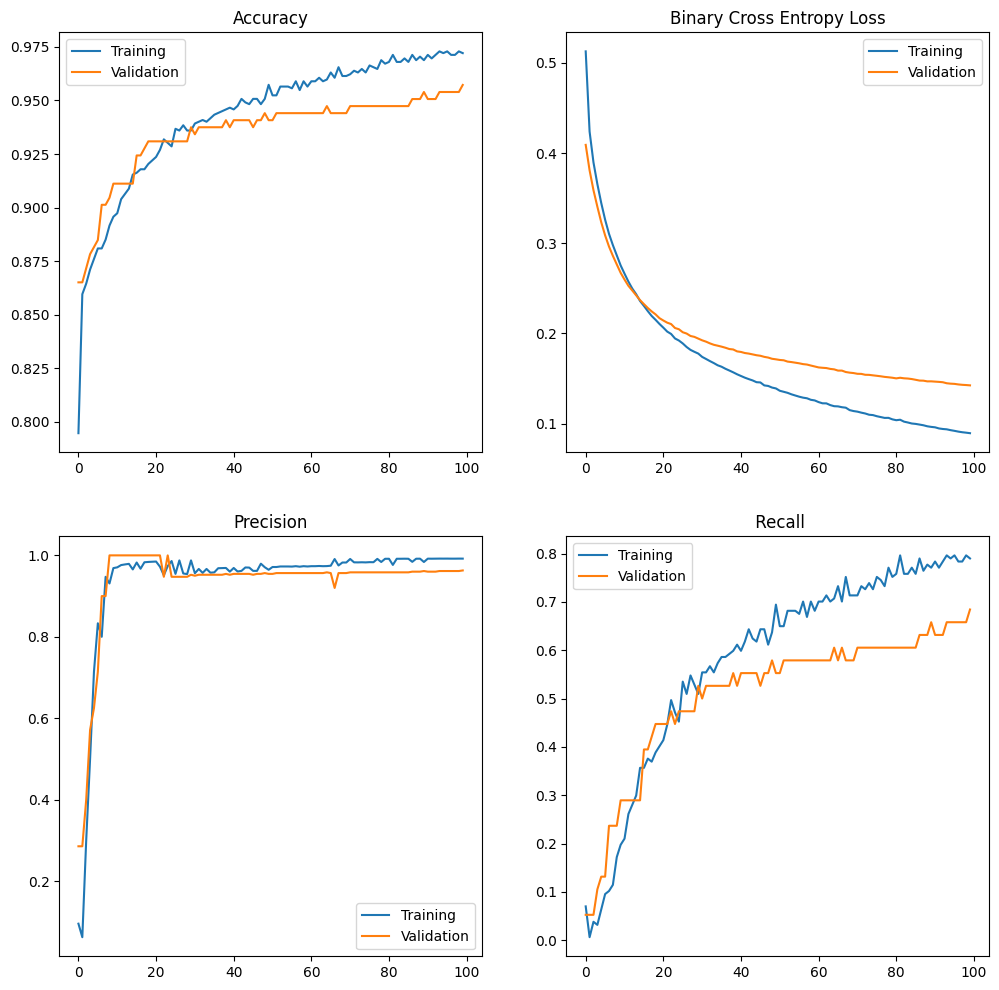

In [ ]:
%matplotlib inline
# EVALUATE
acc = history.history['accuracy']
loss = history.history['loss']
prec = history.history['precision']
recall = history.history['recall']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_prec = history.history['val_precision']
val_recall = history.history['val_recall']

fig, axs = plt.subplots(2,2,figsize=(12,12))

# plot accuracy
axs[0][0].plot(acc, label='Training')
axs[0][0].plot(val_acc, label='Validation')
axs[0][0].set_title('Accuracy')
axs[0][0].legend()

# plot loss
axs[0][1].plot(loss, label='Training')
axs[0][1].plot(val_loss, label='Validation')
axs[0][1].set_title('Binary Cross Entropy Loss')
axs[0][1].legend()

# plot precision
axs[1][0].plot(prec, label='Training')
axs[1][0].plot(val_prec, label='Validation')
axs[1][0].set_title('Precision')
axs[1][0].legend()

# plot recall
axs[1][1].plot(recall, label='Training')
axs[1][1].plot(val_recall, label='Validation')
axs[1][1].set_title(' Recall')
axs[1][1].legend()

plt.savefig('resnettraining',format='jpg')
plt.show()


## Waldo Results
Unfortunately, even with using the high powered, complex CNN of ResNet, we were only able to achieve a recall of about 65% on the Waldo images. While this is a promising start and better than the simple scatter shot or manual search only properly identifying Waldo in two-thirds of images was challenging.  
We came to the conclusion that this problem was most likely due to the highly imbalanced nature of our data set and even the powerful ResNet architecture was struggling to glean enough information from the Waldo images to train on.  
This left us with two options:
- Gather or manually prepare several hundred more Waldo images, in order to reduce the imbalance and give the model more opportunity to learn.
- Pivot to another, similar, problem and data set where there were more balanced classes, and attempt to prove our hypothesis that if we had more Waldo images the problem could be solved.

# Part 2 - Where's Wildfire Dataset

We chose to pivot to another problem and data set where we would have a more balanced data set. We wanted to continue in a binary image classification problem, one that in keeping with our initial Waldo challenge, would consist of many images, with complex backgrounds and noisy images to mimic the Waldo images.  
In doing so, we hope to show that the Waldo issue could be solved, with enough training data, and that the reason for the poor performance was the highly imbalanced nature of the Waldo problem.  
For this purpose, we chose to identify wildfire in aerial and landsccape images.

## Load the Data with TensorFlow

In [ ]:
# The image directory must be in user's Google Drive.
data_path = f'/content/gdrive/My Drive/forest_fire/'

train_image_dir = 'Training_and_Validation/'
test_image_dir = 'Testing/'
resolution = 250

NOTFIRE = 'nofire'
FIRE = 'fire'

In [ ]:
training = data_path + train_image_dir
training

'/content/gdrive/My Drive/forest_fire/Training_and_Validation/'

In [ ]:
# LOAD IMAGE DATASETS
# randomized train/test split, class labeling, batching handled in single step

print('Training Files')
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_path+train_image_dir,
    #batch_size=None,
    labels='inferred',
    class_names=[NOTFIRE,FIRE],
    validation_split=0.2,
    subset='both',
    seed=MY_RANDOM_SEED,
    shuffle=True,
    color_mode='rgb',
    image_size=(resolution,resolution)
)

print('Testing Files')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_path+test_image_dir,
    #batch_size=None,
    labels='inferred',
    class_names=[NOTFIRE,FIRE],
    color_mode='rgb',
    image_size=(resolution,resolution)
)

Training Files
Found 1875 files belonging to 2 classes.
Using 1500 files for training.
Using 375 files for validation.
Testing Files
Found 68 files belonging to 2 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
for i in train_ds, val_ds, test_ds:
  i.prefetch(buffer_size=AUTOTUNE)

In [ ]:
print("num batches",tf.data.experimental.cardinality(train_ds))
for images, classes in train_ds.take(1):
  print("X shape",images.shape)
  print("y shape",classes.shape)

num batches tf.Tensor(47, shape=(), dtype=int64)
X shape (32, 250, 250, 3)
y shape (32,)


# Explore the Training Data

In [ ]:
# unbatch and load to NP so we can get some useful aggregate stats
(train_images,train_labels) = tuple(zip(*train_ds.take(-1)))
train_images = np.concatenate(train_images, axis = 0)/255 # go ahead and scale the data for plt
train_labels = np.concatenate(train_labels, axis = 0)

In [ ]:
# Split the Training Data into Fire and Not-Fire data, for any trends we can infer
filt = np.where(train_labels == 1)
fire_images = train_images[filt]
fire_labels = train_labels[filt]

not_fire_images = np.delete(train_images, filt, axis = 0)
not_fire_labels = np.delete(train_labels, filt, axis = 0)


### X Variable: Image Data - Summary Statistics
* Image data, n arrays of 250x250x3 with continuous values, representing RGB pixel values.
* Values scaled to range(0,1).

In [ ]:
# all the channels are similarly distributed - nothing worth mentioning here
def np_describe(image_data):
  means = [round(np.mean(image_data[:,:,:,i]),3) for i in range(3)]
  sd = [round(np.sqrt(np.var(image_data[:,:,:,i])),3) for i in range(3)]
  mins = [np.min(image_data[:,:,:,i]) for i in range(3)]
  maxs = [np.max(image_data[:,:,:,i]) for i in range(3)]
  n = image_data.shape[0]

  return means, sd, mins, maxs, n

summary_statistics = {'train_summary':np_describe(train_images), \
                      'fire_summary':np_describe(fire_images), \
                      'not_fire_summary':np_describe(not_fire_images) \
                      }

for k, v in summary_statistics.items():
    print(f"RGB Color Channels: {k} \n\n Means  {v[0]}, \n SD     {v[1]}, \n Mins   {v[2]}, \n Maxs   {v[3]} \n n samples {v[4]} \n")


RGB Color Channels: train_summary 

 Means  [0.428, 0.362, 0.294], 
 SD     [0.278, 0.245, 0.264], 
 Mins   [0.0, 0.0, 0.0], 
 Maxs   [1.0, 1.0, 1.0] 
 n samples 1500 

RGB Color Channels: fire_summary 

 Means  [0.472, 0.295, 0.188], 
 SD     [0.289, 0.222, 0.197], 
 Mins   [0.0, 0.0, 0.0], 
 Maxs   [1.0, 1.0, 1.0] 
 n samples 766 

RGB Color Channels: not_fire_summary 

 Means  [0.382, 0.432, 0.404], 
 SD     [0.257, 0.248, 0.28], 
 Mins   [0.0, 0.0, 0.0], 
 Maxs   [1.0, 1.0, 1.0] 
 n samples 734 



### Y Variable: Fire Classification - Summary Statistics

* Binary Classification:
  * 0: not fire
  * 1: fire

In [ ]:
labels, counts = np.unique(train_labels, return_counts = True)
print(f"Training Pct of Data with Fire: {round(np.mean(train_labels)*100,3)}% \nlabels {labels}, counts {counts}")

Training Pct of Data with Fire: 51.067% 
labels [0 1], counts [734 766]


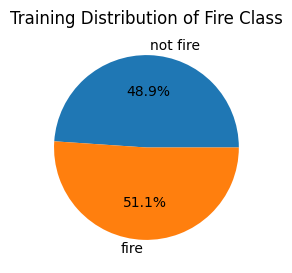

In [ ]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.title('Training Distribution of Fire Class')
plt.pie(counts, labels = ['not fire','fire'],autopct = '%1.1f%%')
plt.show()

### Examine any trends in the images, Fire vs Not Fire

Here we compare the channel distributions between Fire and Not Fire for any interesting differences.

Beyond knowing Fire is labeled in one data set, and not the other, are there any other biases or patterns in the image that would indicate the Fire class? As example, it seems reasonable to expect reds to be more prevalent?

<b> Histogram</b>

Here we compare the channel distributions between Fire and Not Fire, and start to pick up on large differences in color.


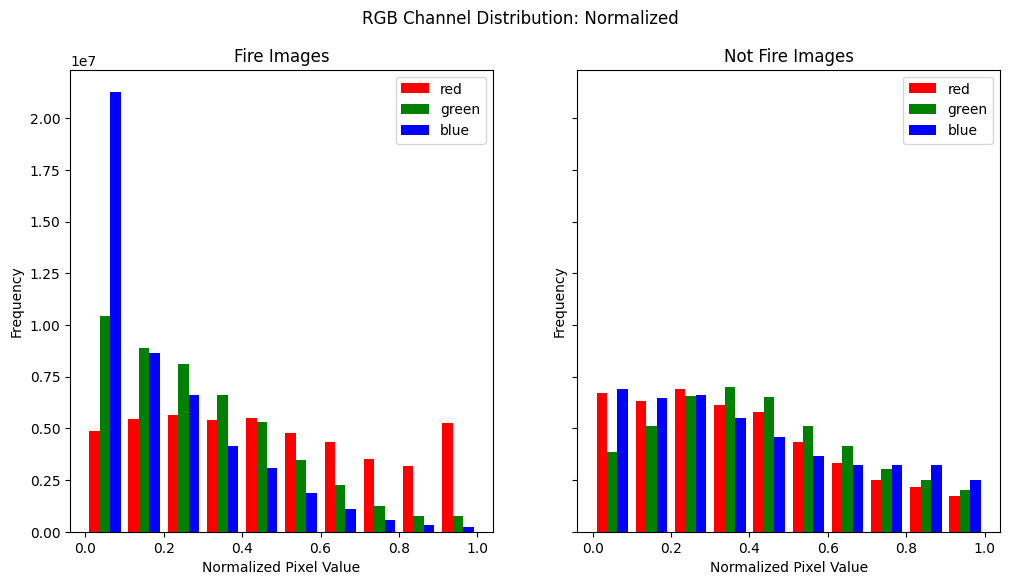

In [ ]:
%matplotlib inline

fig, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(12,6))
fig.suptitle('RGB Channel Distribution: Normalized')
colors = ['red','green','blue']
n,x,y,c = fire_images.shape

ax1.hist(fire_images.reshape((n*x*y),c), color=colors, label=colors)
ax1.set_title('Fire Images')
ax1.set_xlabel('Normalized Pixel Value')
ax1.set_ylabel('Frequency')
ax1.legend()

n,x,y,c = not_fire_images.shape
ax2.hist(not_fire_images.reshape((n*x*y),c), color=colors, label=colors)
ax2.set_title('Not Fire Images')
ax2.set_xlabel('Normalized Pixel Value')
ax2.set_ylabel('Frequency')
ax2.legend()

The channel distributions between the fire/non fire class are very different.

* In the non-fire class, we see the distribution is mostly uniform with a slight left skew.

* In the fire class, we see the majority of the blue channel values in the fire class are very low values, and the red channel values are generally higher.

Below we explored the color distribution and placement across the images in each class.

First we examined the mean pixel RGB value in place for each class.

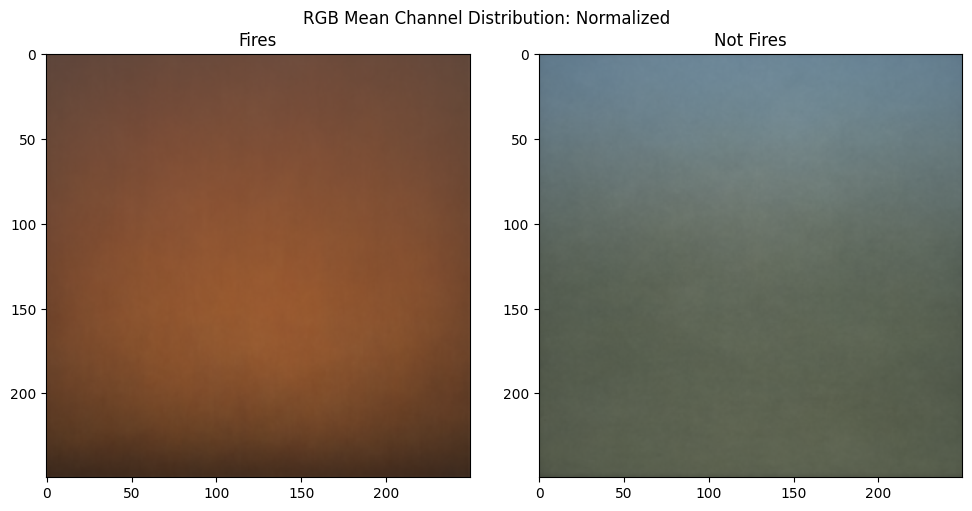

In [ ]:
%matplotlib inline

mean_fires = np.mean(fire_images,axis=0)
mean_not_fires = np.mean(not_fire_images,axis=0)

fig, (ax1, ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))
fig.suptitle('RGB Mean Channel Distribution: Normalized')

ax1.imshow(mean_fires)
ax1.set_title('Fires')
ax2.imshow(mean_not_fires)
ax2.set_title('Not Fires')

plt.tight_layout()
plt.show()

As we would expect, the classes are visibly different, with far more extensive use of reds in the fire class.

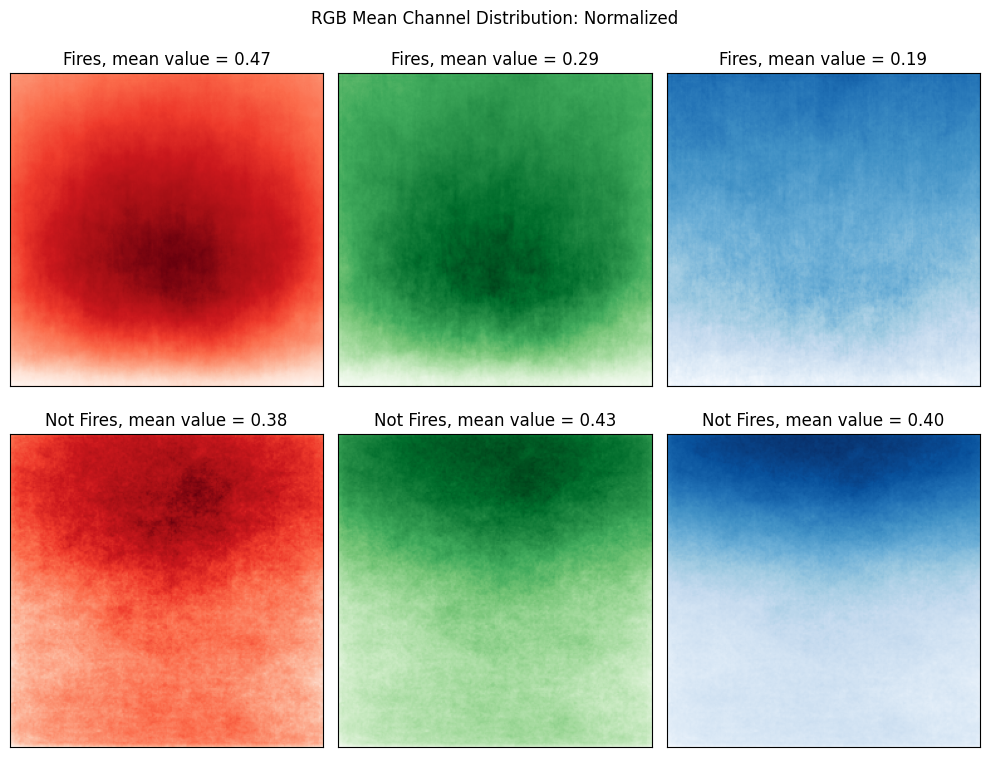

In [ ]:
%matplotlib inline
# split channel mean RGB pixel value in place across the images

mean_fires = np.mean(fire_images,axis=0)
mean_not_fires = np.mean(not_fire_images,axis=0)

fig, axs = plt.subplots(2,3,sharey=False,figsize=(10,8))
fig.suptitle('RGB Mean Channel Distribution: Normalized')
colors = ['Reds','Greens','Blues']

for i in range(len(colors)):
  mean = round(np.mean(mean_fires[:,:,i]),2)
  axs[0][i].imshow(mean_fires[:,:,i],cmap=colors[i])
  axs[0][i].set_title(f'Fires, mean value = {mean:.2f}')
  axs[0][i].get_xaxis().set_ticks([])
  axs[0][i].get_yaxis().set_ticks([])

for i in range(len(colors)):
  mean = round(np.mean(mean_not_fires[:,:,i]),2)
  axs[1][i].imshow(mean_not_fires[:,:,i],cmap=colors[i])
  axs[1][i].set_title(f'Not Fires, mean value = {mean:.2f}')
  axs[1][i].get_xaxis().set_ticks([])
  axs[1][i].get_yaxis().set_ticks([])

plt.tight_layout()
plt.show()

When we split the channels, we also note the darkest reds and greens are near the bottom of the image (where we'd expect fire to usually be, rising from a burning object, probably on the ground toward the air). We can also see how low the blue channel is.

In contrast, the not fire images show more color toward the top of the image, and a much stronger blue channel.

This sheds insight into some of the features the model will probably emphasize:
* the fire class has more red and less blue than the non fire class
* the fire images have stronger color values toward the bottom of the image, while the non fire images have stronger values toward the top.

# Reference Model - Resnet50

ResNet is known to be highly accurate but it's also maximally complex. We expected this model to work well as our benchmark, with our goal to achieve similar accuracy with a far simpler model.

Model Reference https://keras.io/api/applications/resnet/

Steps largely adapted from https://www.tensorflow.org/tutorials/images/transfer_learning


#### Frozen Base Model

In [ ]:
# INSTANTIATE BASE MODEL
base_model = ResNet50(
    weights = 'imagenet',
    classes = 1,
    input_shape = (resolution, resolution, 3),
    include_top = False, # we will keep the convolution layers but add our own waldo classifier
    )

# FREEZE BASE MODEL
base_model.trainable = False

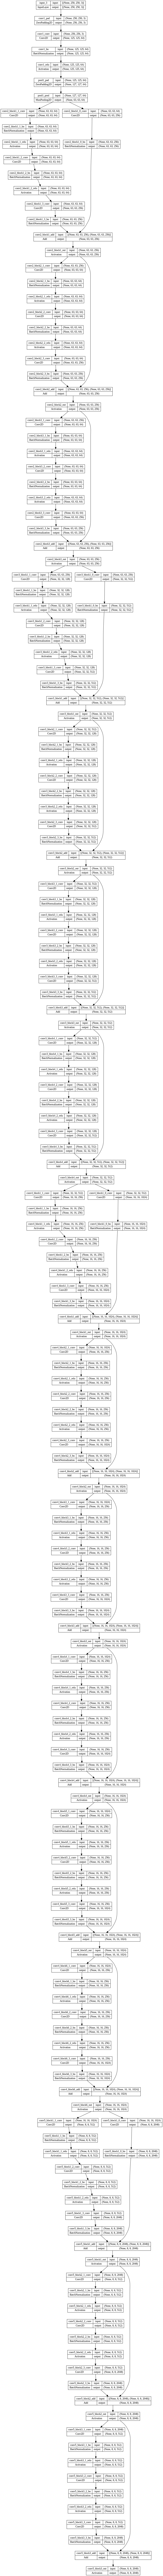

In [ ]:
base_model.summary()
# tf.keras.utils.plot_model(base_model, show_shapes=True)

#### Trainable Classifying and Predicting Layers

In [ ]:
# DEFINE OUR OWN FIRE CLASSIFICATION LAYERS

# FIRE CLASSIFICATION
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# FIRE PREDICTION
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid') # binary class

In [ ]:
# Test the appropriate shapes at each step

# CONVOLUTION OUTPUT
images, classes = next(iter(train_ds))
features = base_model(images)
print(features.shape)

# CLASSIFICATION LAYER
feature_batch_average = global_average_layer(features)
print(feature_batch_average.shape)

# PREDICTION LAYER
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 8, 8, 2048)
(32, 2048)
(32, 1)


#### Model End to End

In [ ]:
# OUR REFERENCE MODEL - END-TO-END
inputs = tf.keras.Input(shape=(resolution, resolution, 3))
x = inputs
# x = data_augmentation(inputs) # ALREADY ADDED AUGMENTED FILES TO DATA
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.30)(x) # REMOVED SINCE THE CONV LAYERS ARE FROZEN
outputs = prediction_layer(x)
resnet_reference_model = tf.keras.Model(inputs, outputs)

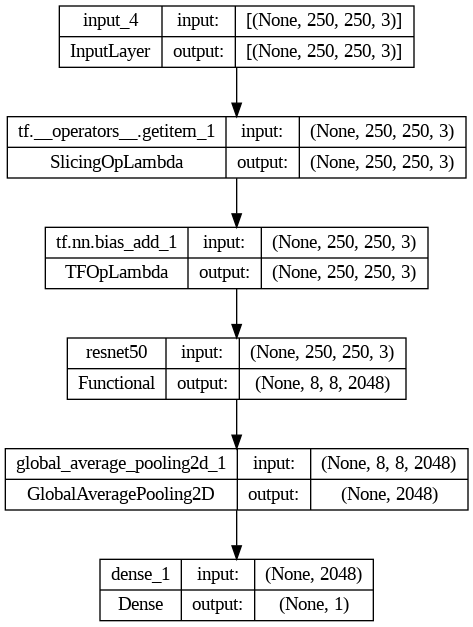

In [ ]:
# # resnet_reference_model.summary()
tf.keras.utils.plot_model(resnet_reference_model, show_shapes=True)

#### Train Top Layers

In [ ]:
# COMPILE - starting out with Keras suggested config
metrics = [tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),
           tf.keras.metrics.TruePositives(name='tp'),
           tf.keras.metrics.FalsePositives(name='fp'),
           tf.keras.metrics.TrueNegatives(name='tn'),
           tf.keras.metrics.FalseNegatives(name='fn'),
           tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')
          ]

base_learning_rate = 0.0001 #0.0005
resnet_reference_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=metrics)

In [ ]:
# TRAIN
initial_epochs = 10

history = resnet_reference_model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs = initial_epochs
                    )
history

Epoch 1/10
47/47 [==============================] - 563s 12s/step - loss: 0.6097 - cross entropy: 0.6097 - tp: 552.0000 - fp: 308.0000 - tn: 426.0000 - fn: 214.0000 - accuracy: 0.6520 - precision: 0.6419 - recall: 0.7206 - auc: 0.7314 - val_loss: 0.4388 - val_cross entropy: 0.4388 - val_tp: 177.0000 - val_fp: 37.0000 - val_tn: 143.0000 - val_fn: 18.0000 - val_accuracy: 0.8533 - val_precision: 0.8271 - val_recall: 0.9077 - val_auc: 0.9319
Epoch 2/10
47/47 [==============================] - 569s 12s/step - loss: 0.3734 - cross entropy: 0.3734 - tp: 709.0000 - fp: 114.0000 - tn: 620.0000 - fn: 57.0000 - accuracy: 0.8860 - precision: 0.8615 - recall: 0.9256 - auc: 0.9634 - val_loss: 0.2847 - val_cross entropy: 0.2847 - val_tp: 184.0000 - val_fp: 7.0000 - val_tn: 173.0000 - val_fn: 11.0000 - val_accuracy: 0.9520 - val_precision: 0.9634 - val_recall: 0.9436 - val_auc: 0.9891
Epoch 3/10
47/47 [==============================] - 526s 11s/step - loss: 0.2546 - cross entropy: 0.2546 - tp: 740.000

#### Evaluate

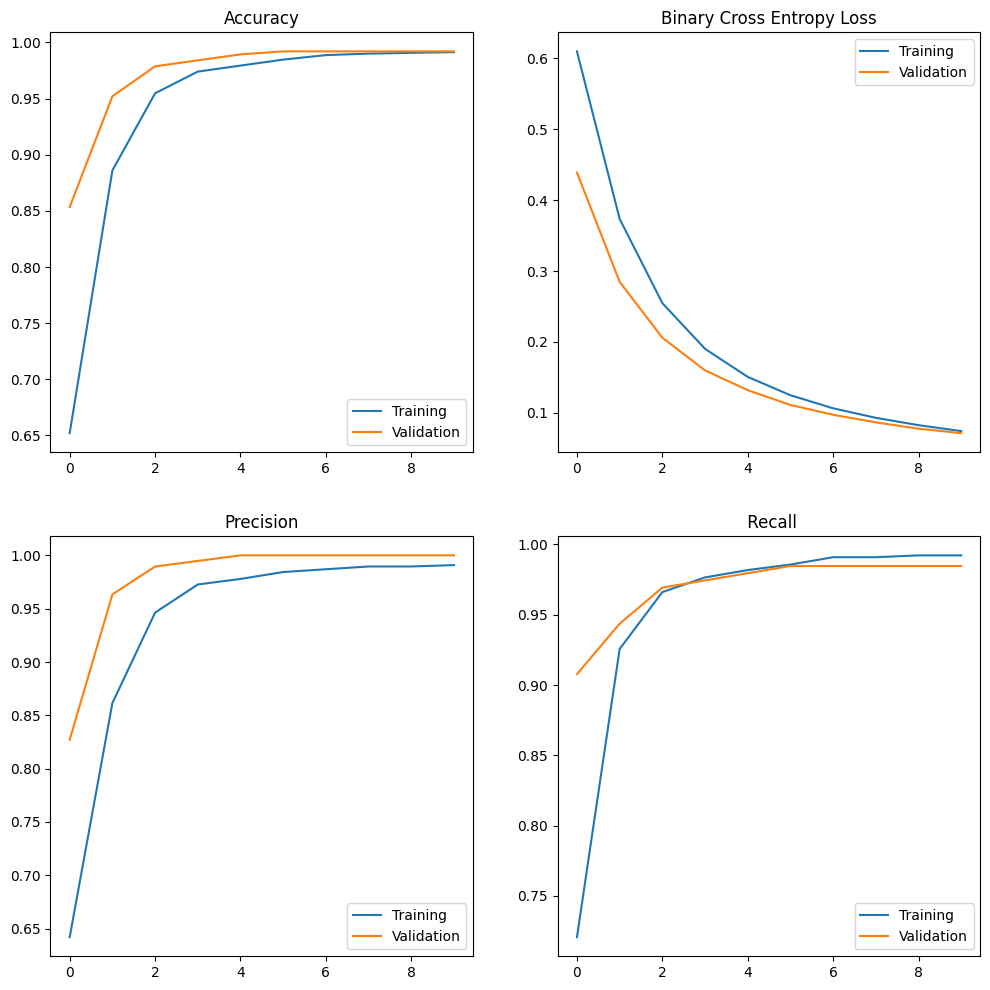

In [ ]:
%matplotlib inline
# EVALUATE
acc = history.history['accuracy']
loss = history.history['loss']
prec = history.history['precision']
recall = history.history['recall']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_prec = history.history['val_precision']
val_recall = history.history['val_recall']

fig, axs = plt.subplots(2,2,figsize=(12,12))

# plot accuracy
axs[0][0].plot(acc, label='Training')
axs[0][0].plot(val_acc, label='Validation')
axs[0][0].set_title('Accuracy')
axs[0][0].legend()

# plot loss
axs[0][1].plot(loss, label='Training')
axs[0][1].plot(val_loss, label='Validation')
axs[0][1].set_title('Binary Cross Entropy Loss')
axs[0][1].legend()

# plot precision
axs[1][0].plot(prec, label='Training')
axs[1][0].plot(val_prec, label='Validation')
axs[1][0].set_title('Precision')
axs[1][0].legend()

# plot recall
axs[1][1].plot(recall, label='Training')
axs[1][1].plot(val_recall, label='Validation')
axs[1][1].set_title(' Recall')
axs[1][1].legend()

plt.savefig('resnettraining',format='jpg')
plt.show()


In stark contrast to the implementation of this model on the Waldo dataset, Resnet was able to reach 99% validation accuracy within 10 epochs. This helps affirm CNN as a very effective way to proceed with our classification problem.

In [ ]:
# PREDICT
# (images_batch1,classes_batch1) = tuple(zip(*train_ds.take(1)))
pred = resnet_reference_model.predict_on_batch(train_images[:10])
pred_labels = list(map(lambda x: 'fire' if x >= 0.5 else 'not fire', pred))

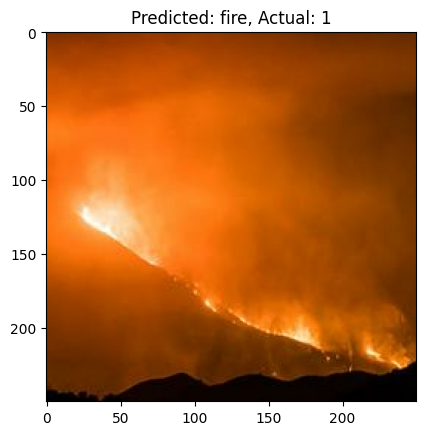

In [ ]:
for i in range(3):
  plt.imshow(train_images[i])
  plt.title(f'Predicted: {pred_labels[i]}, Actual: {train_labels[i]}')

# Reference Model - XGBoost

In [ ]:
# Folder containing the image files
#fire_train_path = '/content/gdrive/My Drive/forest_fire/Training_Validation/fire'
#nofire_train_path = '/content/gdrive/My Drive/forest_fire/Training_Validation/nofire'
fire_train_path = '/content/gdrive/My Drive/forest_fire/Training_and_Validation/fire'
nofire_train_path = '/content/gdrive/My Drive/forest_fire/Training_and_Validation/nofire'
fire_test_path = '/content/gdrive/My Drive/forest_fire/Testing/fire'
nofire_test_path = '/content/gdrive/My Drive/forest_fire/Testing/nofire'

paths= [fire_train_path, nofire_train_path, fire_test_path, nofire_test_path]

# Define image dimensions
width, height = 250, 250

# Initialize arrays to store image data and labels
image_data = []
labels = []
i=1
for path in paths:
    # List all image files in the folder
    image_files = [f for f in os.listdir(path) if f.endswith('.jpg')]

    # Process each image file
    for filename in image_files:
        # Load the image
        img = Image.open(os.path.join(path, filename))

        # Resize the image to desired dimensions
        img = img.resize((width, height))

        # Convert the image to grayscale
        img = img.convert('L')

        # Convert to numeric representation (flatten)
        img_array = np.array(img).flatten()

        # Add a final value to the array indicating the label
        if path.endswith('nofire'):
            label = 0
        else:
            label = 1
        img_array_with_label = np.append(img_array, label)
        # Append image array to the list
        image_data.append(img_array_with_label)
        i+=1
# Convert list to numpy array
image_data = np.array(image_data)
flat_images_df = pd.DataFrame(image_data)

In [ ]:
#Create X & y sets
flat_X=flat_images_df.copy().drop(columns=[62500])
flat_y=flat_images_df[62500]
#Split into train and test
flat_X_train, flat_X_test, flat_y_train, flat_y_test=train_test_split(flat_X, flat_y, train_size=.7, random_state=1506)

In [ ]:
len(flat_y_train)

666

In [ ]:
#Fit an XGBoost classifier
xgb=GradientBoostingClassifier(max_features='log2', random_state=36)
xgb.fit(flat_X_train, flat_y_train)

GradientBoostingClassifier(max_features='log2', random_state=36)

In [ ]:
#Make preditcions on the test images
xgb_preds=xgb.predict(flat_X_test)

In [ ]:
scores=np.empty((0,4))
#Records metrics of the XGBoost predictions
scores=np.append(scores,[[accuracy_score(flat_y_test,xgb_preds), precision_score(flat_y_test,xgb_preds), recall_score(flat_y_test,xgb_preds), f1_score(flat_y_test,xgb_preds)]], axis=0)
#Create a confusion matrix
cmxgb=confusion_matrix(flat_y_test,xgb_preds)
print(cmxgb)
print(f'Accuracy of the XGBoost model is: {round(scores[0][0],4)}')
print(f'Precision of the XGBoost model is: {round(scores[0][1],4)}')
print(f'Recall of the XGBoost model is: {round(scores[0][2],4)}')
print(f'F1 score of the XGBoost model is: {round(scores[0][3],4)}')

[[216  57]
 [ 79 233]]
Accuracy of the XGBoost model is: 0.7675
Precision of the XGBoost model is: 0.8034
Recall of the XGBoost model is: 0.7468
F1 score of the XGBoost model is: 0.7741


The XGBoost model performed reasonably well, achieving 77% accuracy. This model obviously does not perform nearly to the level as the ResNet50, at over 99% accuracy, but is also far less complex to train. Only being able to determine whether or not a fire is present 3 out of 4 timeswould likely not be acceptable, in terms of the applicability of XGBoost.  

We will seek to achieve an accuracy greater than that of the XGBoost machine learning baseline and hope to obtain accuracy rivaling that of the ResNet50 model, but with less complexity.

# Where's Wildfire?
## Model Creation
This our "built by hand" approach at classifying the Wildfire images using a CNN architecture. This will utilize 250x250 pixel color images of two classes, fire and no fire.  
#### Goal:
To create a neural network model which will classify images at greater than 77% accuracy, which is our baseline achieved via a traditional machine learning techinique of Gradient Boosted Trees. Further, we hope to build a model which has more simple architecture than ResNet50, while approaching a similar result, of 99% accuracy.
#### Approach:
We will begin with a basic CNN architecture and through evaluation of performance iterate upon the results to improve our model.

In [7]:
#Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, RocCurveDisplay, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import relu, sigmoid, swish
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Image Prep
Load the image data and prepare it for training, splitting into train and validation sets, with 20% allocated to validation.

In [ ]:
#Image Directory
image_folder='/content/gdrive/My Drive/forest_fire/Training_and_Validation'

#ImageDataGenerator to scale images and then split into training and validation sets
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)

#Set image specifications
image_height=250
image_width=250
batch_size=50

#Load and split the data
train_generator=datagen.flow_from_directory(
        image_folder,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='binary',
        subset='training')

validation_generator=datagen.flow_from_directory(
        image_folder,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='binary',
        subset='validation')


Found 1501 images belonging to 2 classes.
Found 374 images belonging to 2 classes.


In [ ]:
#Quick check of the split in training data
sum(train_generator.labels)

733

Load testing data, which is a holdout set of 68 images. These will be used for evaluation on a final model.  
The processing of these images is done in a loop of the testing directories rather than building a generator object as done for the training and validation sets.  
Due to the naming convention of the image folders, the label for fire is 0 and the label for no fire is 1.

In [ ]:
#Create list of directories to search for test images
test_nofire_dir = '/content/gdrive/My Drive/forest_fire/Testing/nofire'
test_fire_dir = '/content/gdrive/My Drive/forest_fire/Testing/fire'
test_dir=[test_nofire_dir,test_fire_dir]

#Lists to hold test images and the associated labels
testing_images = []
testing_labels = []

#For loop to iterate through the diretories
for dir in test_dir:
    for img_name in os.listdir(dir):
        img_path = os.path.join(dir, img_name)

        #Load image
        img = Image.open(img_path)

        #Ensure image is sized properly
        img = img.resize((250, 250))

        #Convert image to numpy array and scale
        img_array = np.array(img)
        img_array = img_array / 255.0

        #Append the image and its label to the lists
        testing_images.append(img_array)

        #Assign label based on directory name
        if dir.endswith('nofire'):
            testing_labels.append(1)  #No fire is labeled as 1 due to directory file structure in training images
        else:
            testing_labels.append(0)  #Fire labeled as 0

# Convert lists to numpy arrays
testing_images = np.array(testing_images)
testing_labels = np.array(testing_labels)

## Single Layer CNN - Base Model
Starting with a very basic single layer model. One convolutional layer of 32 kernals, a pooling layer, followed by a dense layer. This single layer model has 15.7 million parameters.

In [ ]:
#Create sequential model
single_layer=Sequential()
single_layer.add(Conv2D(32, (3,3), activation='relu', input_shape=(250,250,3)))
single_layer.add(MaxPooling2D(pool_size=(2,2)))
single_layer.add(Flatten())
single_layer.add(Dense(32, activation='relu'))
single_layer.add(Dense(1, activation='sigmoid'))

single_layer.compile(optimizer='adam', loss=BinaryCrossentropy() , metrics=[keras.metrics.Accuracy()])

In [ ]:
single_layer.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 492032)            0         
                                                                 
 dense (Dense)               (None, 32)                15745056  
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 15745985 (60.07 MB)
Trainable params: 15745985 (60.07 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [ ]:
#Train single layer
single_history = single_layer.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/50
29/29 [==============================] - 744s 26s/step - loss: 1.5874 - accuracy: 0.0368 - val_loss: 0.3455 - val_accuracy: 0.0057
Epoch 2/50
29/29 [==============================] - 10s 330ms/step - loss: 0.1583 - accuracy: 0.0021 - val_loss: 0.2384 - val_accuracy: 0.0000e+00
Epoch 3/50
29/29 [==============================] - 10s 329ms/step - loss: 0.1287 - accuracy: 6.9348e-04 - val_loss: 0.2528 - val_accuracy: 0.0000e+00
Epoch 4/50
29/29 [==============================] - 10s 348ms/step - loss: 0.1240 - accuracy: 0.0021 - val_loss: 0.2352 - val_accuracy: 0.0000e+00
Epoch 5/50
29/29 [==============================] - 10s 351ms/step - loss: 0.1029 - accuracy: 0.0021 - val_loss: 0.2318 - val_accuracy: 0.0000e+00
Epoch 6/50
29/29 [==============================] - 9s 318ms/step - loss: 0.0875 - accuracy: 0.0021 - val_loss: 0.2312 - val_accuracy: 0.0000e+00
Epoch 7/50
29/29 [==============================] - 10s 357ms/step - loss: 0.0782 - accuracy: 0.0042 - val_loss: 0.2189 

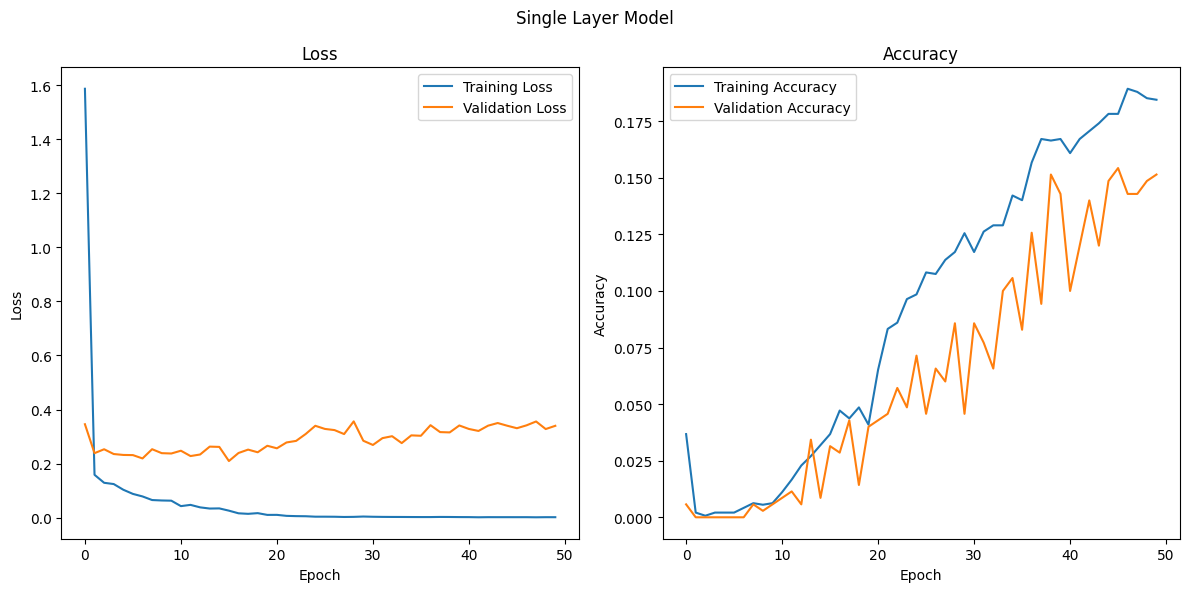

In [ ]:
#Retrieve the training and validation loss
train_loss=single_history.history['loss']
val_loss=single_history.history['val_loss']

#Retrieve the training and validation accuracy
train_acc = single_history.history['accuracy']
val_acc = single_history.history['val_accuracy']

fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

#Plot training and validation loss
axs[0].plot(train_loss, label='Training Loss')
axs[0].plot(val_loss, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss')
axs[0].legend()

#Plot training and validation accuracy
axs[1].plot(train_acc, label='Training Accuracy')
axs[1].plot(val_acc, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy')
axs[1].legend()

fig1.suptitle('Single Layer Model')
plt.tight_layout()
plt.show()

The single convolutional layer performs poorly in classifying the images. After 50 epochs, although the accuracy is still increasing, it has only achieved about 15% accuracy on the validation set. While longer training may continue to increase the result, the model has difficulty learning enough information from the features in the single layer. Increasing the complexity will provide the model with more features and allow it to construct higher level combinations of features to improve the learning ability.

## Three Layer CNN - Model Iteration #1
The model will consist of 3 convolutional layers followed by 1 dense layer and then the output layer, utilizing sigmoid function for probability of image containing fire.  
Parameters: 59 million  
4x more than single layer

In [ ]:
#Set initial CNN model layers
three_layer_model=Sequential()

three_layer_model.add(Conv2D(32, (3,3), activation='relu', input_shape=(250,250,3)))

three_layer_model.add(Conv2D(64, (3,3), activation='relu'))
three_layer_model.add(MaxPooling2D(pool_size=(2,2)))

three_layer_model.add(Conv2D(128, (3,3), activation='relu'))
three_layer_model.add(MaxPooling2D(pool_size=(2,2)))

three_layer_model.add(Flatten())
three_layer_model.add(Dense(128, activation='relu'))
three_layer_model.add(Dense(1, activation='sigmoid'))

three_layer_model.compile(optimizer='adam', loss=BinaryCrossentropy() , metrics=[keras.metrics.Accuracy()])

In [ ]:
three_layer_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 248, 248, 32)      896       
                                                                 
 conv2d_2 (Conv2D)           (None, 246, 246, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 123, 123, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 121, 121, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 460800)           

In [ ]:
#Train the three layer model
history1 = three_layer_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/50
29/29 [==============================] - 30s 662ms/step - loss: 1.1381 - accuracy: 0.0319 - val_loss: 0.2875 - val_accuracy: 0.0000e+00
Epoch 2/50
29/29 [==============================] - 11s 365ms/step - loss: 0.1205 - accuracy: 0.0049 - val_loss: 0.2302 - val_accuracy: 0.0029
Epoch 3/50
29/29 [==============================] - 10s 341ms/step - loss: 0.1146 - accuracy: 0.0125 - val_loss: 0.1945 - val_accuracy: 0.0029
Epoch 4/50
29/29 [==============================] - 16s 542ms/step - loss: 0.0691 - accuracy: 0.0340 - val_loss: 0.1949 - val_accuracy: 0.0257
Epoch 5/50
29/29 [==============================] - 14s 465ms/step - loss: 0.0568 - accuracy: 0.0589 - val_loss: 0.2335 - val_accuracy: 0.0286
Epoch 6/50
29/29 [==============================] - 11s 373ms/step - loss: 0.0490 - accuracy: 0.1026 - val_loss: 0.2302 - val_accuracy: 0.0914
Epoch 7/50
29/29 [==============================] - 11s 359ms/step - loss: 0.0303 - accuracy: 0.1255 - val_loss: 0.3818 - val_accuracy: 0.

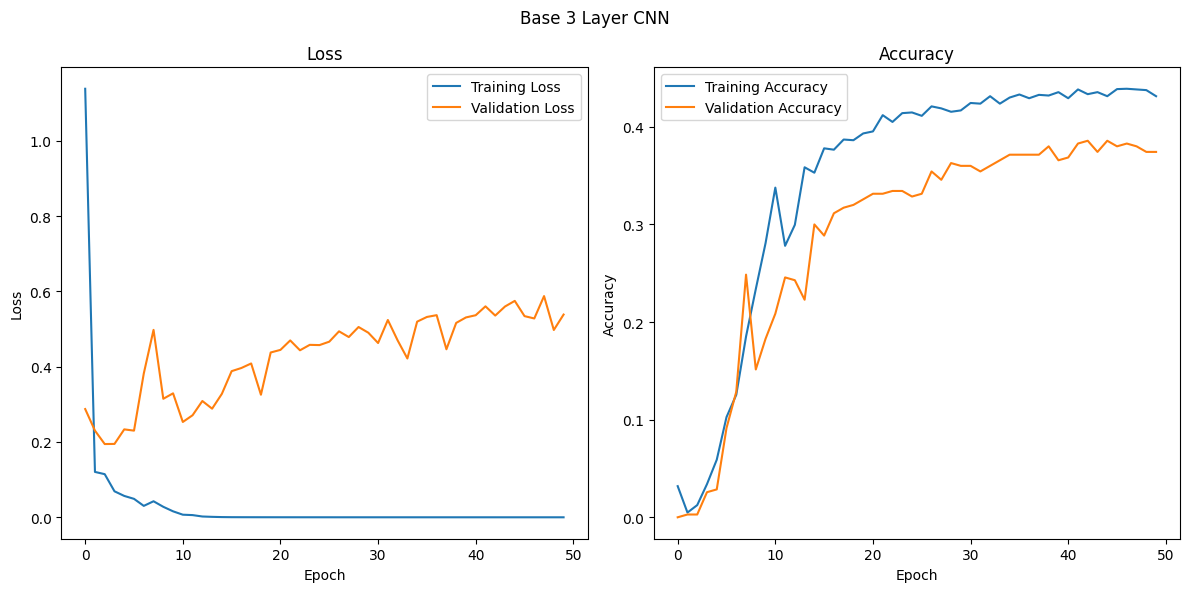

In [ ]:
#Retrieve the training and validation loss
train_loss=history1.history['loss']
val_loss=history1.history['val_loss']

#Retrieve the training and validation accuracy
train_acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

fig2, axs = plt.subplots(1, 2, figsize=(12, 6))

#Plot training and validation loss
axs[0].plot(train_loss, label='Training Loss')
axs[0].plot(val_loss, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss')
axs[0].legend()

#Plot training and validation accuracy
axs[1].plot(train_acc, label='Training Accuracy')
axs[1].plot(val_acc, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy')
axs[1].legend()

fig2.suptitle('3 Layer CNN')
plt.tight_layout()
plt.show()

8/8 [==============================] - 3s 435ms/step
Confusion Matrix:
[[94 95]
 [98 85]]


<function matplotlib.pyplot.show(close=None, block=None)>

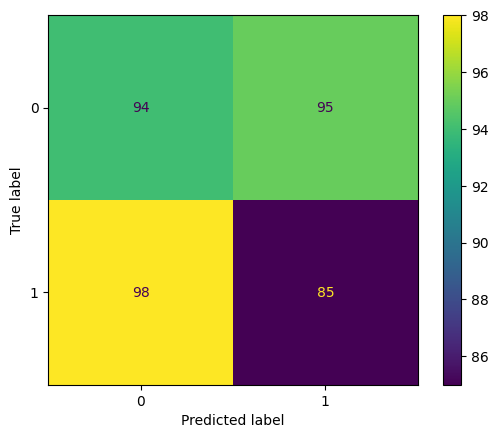

In [ ]:
#Generate predictions on validation data
y_pred_prob = three_layer_model.predict(validation_generator)

#Convert probabilities to binary predictions
y_pred = np.round(y_pred_prob)

#Extract true labels from the generator
true_labels = validation_generator.classes

#Construct confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred)

#Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

cm_display = ConfusionMatrixDisplay(conf_matrix)
cm_display.plot()
plt.show

In the 3 layer CNN, the accuracy on the training data approached 45% and about 40% on the validation data. While improved over the single layer, the model continues underperforming. After 30 epochs the model accuracy seems to have plateaued, around 45% on the training data, while the loss on training data has become quite small and also leveled out. This indicates that while the model has diminished the loss to a negligible level, there is still room for improvement. The model has extracted as much information as it can with this architecture.  
To improve the model further we need to continue to increase the complexity.

## Model Iteration #2
In this model, we'll add padding to retain information near the edges of the images. The number of kernals is doubled at each layer to build more features for the model to learn from. Add dropout in the dense layer to prevent overfitting and keep the loss function on the training data from declining too quickly, as we saw in the previous iteration.  
Parameters: 250 million  
15x increase over single layer model

In [ ]:
#Double filters with each convolution layer and add dropout.
#Change the padding to same to retain edge features

model2 = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(image_height, image_width, 3)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    Dropout(0.5),
    #Add dropout layer with dropout rate of 0.5
    layers.Dense(1, activation='sigmoid')
])

#Compile the model with weighted binary cross-entropy loss
model2.compile(optimizer='adam', loss=BinaryCrossentropy() , metrics=[keras.metrics.Accuracy()])

In [ ]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 250, 250, 64)      1792      
                                                                 
 conv2d_11 (Conv2D)          (None, 250, 250, 128)     73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 125, 125, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 125, 125, 256)     295168    
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 62, 62, 256)       0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 984064)           

In [ ]:
#Train the base model
history2 = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/50
29/29 [==============================] - 32s 1s/step - loss: 2.4399 - accuracy: 0.0153 - val_loss: 0.2950 - val_accuracy: 0.0000e+00
Epoch 2/50
29/29 [==============================] - 28s 966ms/step - loss: 0.2166 - accuracy: 0.0104 - val_loss: 0.2347 - val_accuracy: 0.0057
Epoch 3/50
29/29 [==============================] - 28s 965ms/step - loss: 0.1341 - accuracy: 0.0388 - val_loss: 0.2724 - val_accuracy: 0.0086
Epoch 4/50
29/29 [==============================] - 29s 996ms/step - loss: 0.1185 - accuracy: 0.0832 - val_loss: 0.2100 - val_accuracy: 0.0286
Epoch 5/50
29/29 [==============================] - 28s 970ms/step - loss: 0.0896 - accuracy: 0.0874 - val_loss: 0.2360 - val_accuracy: 0.0086
Epoch 6/50
29/29 [==============================] - 29s 990ms/step - loss: 0.1324 - accuracy: 0.0687 - val_loss: 0.3487 - val_accuracy: 0.0343
Epoch 7/50
29/29 [==============================] - 29s 986ms/step - loss: 0.1260 - accuracy: 0.0728 - val_loss: 0.2636 - val_accuracy: 0.097

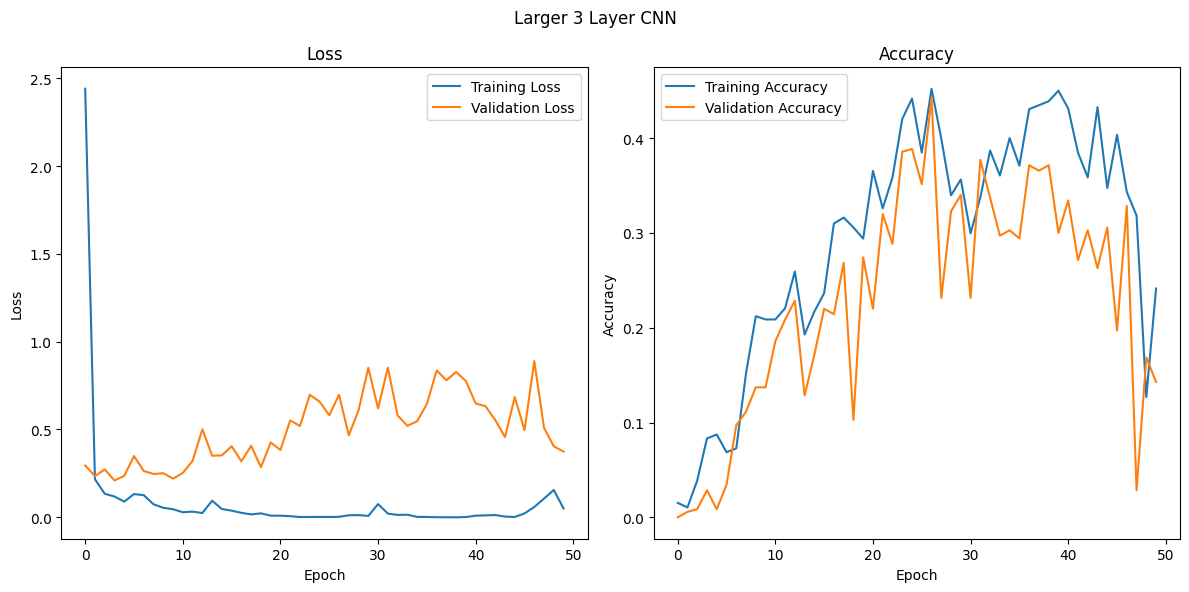

In [ ]:
#Retrieve the training and validation loss
train_loss=history2.history['loss']
val_loss=history2.history['val_loss']

#Retrieve the training and validation accuracy
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

fig3, axs = plt.subplots(1, 2, figsize=(12, 6))

#Plot training and validation loss
axs[0].plot(train_loss, label='Training Loss')
axs[0].plot(val_loss, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss')
axs[0].legend()

#Plot training and validation accuracy
axs[1].plot(train_acc, label='Training Accuracy')
axs[1].plot(val_acc, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy')
axs[1].legend()

fig3.suptitle('Larger 3 Layer CNN')
plt.tight_layout()
plt.show()

Adding the dropout created more flucuation in the accuracy. The model peaked at about the same accuracy but then began to decline with more epochs. The dropout in the dense layer did not have the intended effect. It appears that starting the model with 64 layers in the first layer, may not have improved the model's ability to obtain more information from the additional features. We may need to build those features more slowly.

## Model Iteration #3
Here we will add a 4th convolutional layer and group the convolution layers in twos, followed by a pooling layer for downsampling. We change the starting number of layers back to 32, and then apply the doubling at each subsequent layer to help the model build from small features into larger feature compilations. With the larger number of layers in the last conolutional layer we add a second fully connected layer and decrease the neurons by half in the second dense layer. Based on the result of the last model and with little evidence of overfitting in the base model, we will remove the dropout in the dense layers. Our goal is to find a model which fits well to the training data, even if it overfits, before attempting to remove any overfitting.  
Parameters: 252 million  
16x over single layer

In [ ]:
#Double filters with each convolution layer.
#Remove dropout and add a second connected layer

model3 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_height, image_width, 3)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with weighted binary cross-entropy loss
model3.compile(optimizer='adam', loss=BinaryCrossentropy() , metrics=[keras.metrics.Accuracy()])

In [ ]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 125, 125, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 256)     295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 256)       0         
 g2D)                                                   

In [ ]:
#Due to the size of the model, need to create small batches for it to run on
#Set image specifications
image_height=250
image_width=250

#Reduce the batch size for larger model
small_batch_size=25

#Load and split the data
train_generator2=datagen.flow_from_directory(
        image_folder,
        target_size=(image_height, image_width),
        batch_size=small_batch_size,
        class_mode='binary',
        subset='training')

validation_generator2=datagen.flow_from_directory(
        image_folder,
        target_size=(image_height, image_width),
        batch_size=small_batch_size,
        class_mode='binary',
        subset='validation')

Found 1501 images belonging to 2 classes.
Found 374 images belonging to 2 classes.


In [ ]:
#Train the deeper model

history3 = model3.fit(
    train_generator2,
    steps_per_epoch=train_generator2.samples // small_batch_size,
    epochs=50,
    validation_data=validation_generator2,
    validation_steps=validation_generator2.samples // small_batch_size,
)

Epoch 1/50
59/59 [==============================] - 568s 9s/step - loss: 0.9532 - accuracy: 0.0204 - val_loss: 0.3423 - val_accuracy: 0.0000e+00
Epoch 2/50
59/59 [==============================] - 12s 206ms/step - loss: 0.1381 - accuracy: 0.0123 - val_loss: 0.4085 - val_accuracy: 0.0000e+00
Epoch 3/50
59/59 [==============================] - 12s 206ms/step - loss: 0.1554 - accuracy: 0.0320 - val_loss: 0.2751 - val_accuracy: 0.0514
Epoch 4/50
59/59 [==============================] - 12s 206ms/step - loss: 0.1097 - accuracy: 0.0723 - val_loss: 0.2192 - val_accuracy: 0.0971
Epoch 5/50
59/59 [==============================] - 12s 204ms/step - loss: 0.0814 - accuracy: 0.0941 - val_loss: 0.2183 - val_accuracy: 0.0971
Epoch 6/50
59/59 [==============================] - 12s 201ms/step - loss: 0.0571 - accuracy: 0.2093 - val_loss: 0.6612 - val_accuracy: 0.2657
Epoch 7/50
59/59 [==============================] - 12s 203ms/step - loss: 0.1095 - accuracy: 0.1363 - val_loss: 1.0393 - val_accuracy: 

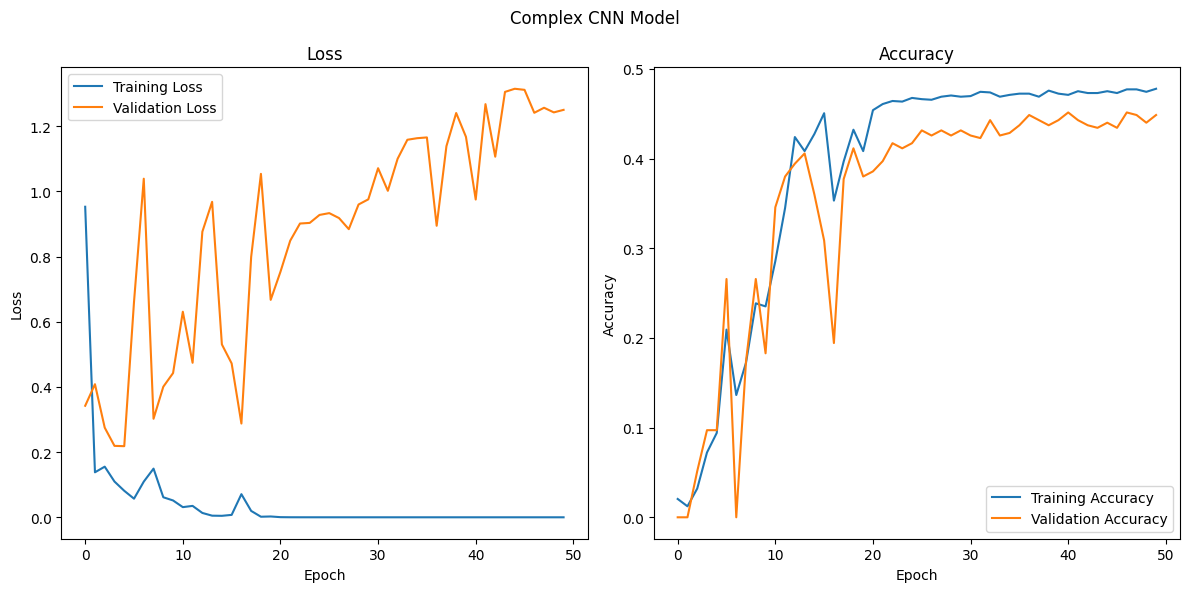

In [ ]:
#Retrieve the training and validation loss
train_loss=history3.history['loss']
val_loss=history3.history['val_loss']

#Retrieve the training and validation accuracy
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

fig4, axs = plt.subplots(1, 2, figsize=(12, 6))

#Plot training and validation loss
axs[0].plot(train_loss, label='Training Loss')
axs[0].plot(val_loss, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss')
axs[0].legend()

#Plot training and validation accuracy
axs[1].plot(train_acc, label='Training Accuracy')
axs[1].plot(val_acc, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy')
axs[1].legend()

fig4.suptitle('Complex CNN Model')
plt.tight_layout()
plt.show()

The more complex model improved the accuracy marginally, nearing 50% on the training data, while the validation data was nearing 45% and more closely related to the training accuracy. The model performs no better than a coin flip. The accuracy plateaued at about epoch 20, where the loss on the training data reached $10^{-5}$

## Model 3 w/ Dropout
In the previous model, Model 3, we saw the loss function on the training data drop to near 0 after only 20 epochs. This is similar to what we observed in the three layer CNN model. When we added the dropout in Model 2, we observed the loss function flucuate across all the training epochs, allowing the model to continue to learn through back propogation for longer.  
Here, we are adding dropout back into the dense layers as a regularization to prevent overfitting and allow the model to learn longer. We extend the training for more epochs to allow for fluctuation in the loss due to dropout. The goal of adding dropout is to keep the loss in the model at a high enough level that the model may be able to learn more nuance in the data.

In [ ]:
#Double filters with each convolution layer.
#Add dropout to both connected layers

model3_dropout = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_height, image_width, 3)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with weighted binary cross-entropy loss
model3_dropout.compile(optimizer='adam', loss=BinaryCrossentropy() , metrics=[keras.metrics.Accuracy()])

In [ ]:
model3_dropout.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 125, 125, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 256)     295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 256)       0         
 g2D)                                                   

In [ ]:
#Train the deeper model

history3_dropout = model3_dropout.fit(
    train_generator2,
    steps_per_epoch=train_generator2.samples // small_batch_size,
    epochs=150,
    validation_data=validation_generator2,
    validation_steps=validation_generator2.samples // small_batch_size,
)

Epoch 1/150
59/59 [==============================] - 337s 5s/step - loss: 0.5044 - accuracy: 0.0402 - val_loss: 0.3234 - val_accuracy: 0.0029
Epoch 2/150
59/59 [==============================] - 18s 307ms/step - loss: 0.1909 - accuracy: 0.0832 - val_loss: 0.2925 - val_accuracy: 0.0257
Epoch 3/150
59/59 [==============================] - 19s 315ms/step - loss: 0.1582 - accuracy: 0.0845 - val_loss: 0.3329 - val_accuracy: 0.0771
Epoch 4/150
59/59 [==============================] - 19s 328ms/step - loss: 0.1404 - accuracy: 0.1316 - val_loss: 0.2228 - val_accuracy: 0.0714
Epoch 5/150
59/59 [==============================] - 18s 311ms/step - loss: 0.0910 - accuracy: 0.1643 - val_loss: 0.4714 - val_accuracy: 0.3057
Epoch 6/150
59/59 [==============================] - 19s 323ms/step - loss: 0.1098 - accuracy: 0.2263 - val_loss: 0.4069 - val_accuracy: 0.2771
Epoch 7/150
59/59 [==============================] - 19s 325ms/step - loss: 0.0819 - accuracy: 0.2420 - val_loss: 0.3655 - val_accuracy: 0

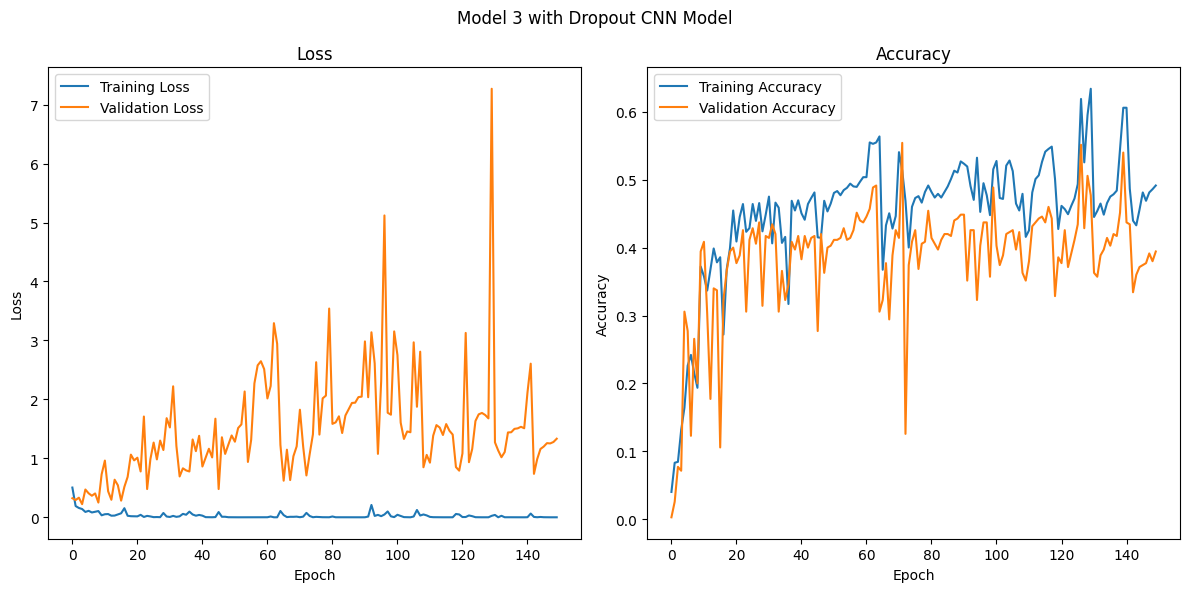

In [ ]:
#Retrieve the training and validation loss
train_loss=history3_dropout.history['loss']
val_loss=history3_dropout.history['val_loss']

#Retrieve the training and validation accuracy
train_acc = history3_dropout.history['accuracy']
val_acc = history3_dropout.history['val_accuracy']

fig6, axs = plt.subplots(1, 2, figsize=(12, 6))

#Plot training and validation loss
axs[0].plot(train_loss, label='Training Loss')
axs[0].plot(val_loss, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss')
axs[0].legend()

#Plot training and validation accuracy
axs[1].plot(train_acc, label='Training Accuracy')
axs[1].plot(val_acc, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy')
axs[1].legend()

fig6.suptitle('Model 3 with Dropout CNN Model')
plt.tight_layout()
plt.show()

While the model did perform slightly better with the dropout, allowing it to improve over a longer training period, the end result was still slightly less than 50% on training data and 40% on validation.  
We are continuing to see a ceiling at about 50% accuracy on training. The value of the loss function on the validation data being much higher than on the training data indicates there are things the model is currently unable to learn from the data. Coupled with the fact that the model fails to break 50% accuracy and we know the ResNet model is capable of learning significantly more information to achieve a higher accuracy, we are going to continue to increase the complexity of the model to attempt to draw out this information from the images.

## Model Iteration #4
We are going to attempt to provide the model with the ability to create more complex and broader features. To accomplish this we add another group of convolutions increasing the kernals to 256 and increasing the number of neurons in the dense layers to attempt to give the model the ability to learn broader concepts in the images. We will now have 3 pairs of convultional layers, with a max pooling layer following each pair. We also removed the padding in this attempt to see to prevent the number of parameters in the model from growing too large. Since the loss function dropped to 0 so quickly in the last model, add in dropout at 30% in the dense layers to prevent overfitting. Extending training epochs to account for more fluctuation in the loss due to dropout.  
Parameters: 97 million  
6x the base model

In [ ]:
#Add third set of convolutions.
#Remove padding and add dropoout

model4 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with weighted binary cross-entropy loss
model4.compile(optimizer='adam', loss=BinaryCrossentropy() , metrics=[keras.metrics.Accuracy()])

In [ ]:
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 248, 248, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 246, 246, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 123, 123, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 121, 121, 128)     73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 119, 119, 128)     147584    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 59, 59, 128)       0         
 g2D)                                                 

In [ ]:
#Train the deeper model

history4 = model4.fit(
    train_generator2,
    steps_per_epoch=train_generator2.samples // small_batch_size,
    epochs=150,
    validation_data=validation_generator2,
    validation_steps=validation_generator2.samples // small_batch_size,
)

Epoch 1/150
59/59 [==============================] - 21s 301ms/step - loss: 0.5723 - accuracy: 0.0000e+00 - val_loss: 0.3058 - val_accuracy: 0.0000e+00
Epoch 2/150
59/59 [==============================] - 18s 301ms/step - loss: 0.2143 - accuracy: 0.0027 - val_loss: 0.2932 - val_accuracy: 0.0057
Epoch 3/150
59/59 [==============================] - 16s 274ms/step - loss: 0.1702 - accuracy: 0.0130 - val_loss: 0.2835 - val_accuracy: 0.0200
Epoch 4/150
59/59 [==============================] - 17s 287ms/step - loss: 0.1585 - accuracy: 0.0136 - val_loss: 0.3070 - val_accuracy: 0.0000e+00
Epoch 5/150
59/59 [==============================] - 16s 273ms/step - loss: 0.1311 - accuracy: 0.0170 - val_loss: 0.3161 - val_accuracy: 0.0229
Epoch 6/150
59/59 [==============================] - 17s 292ms/step - loss: 0.1957 - accuracy: 0.0348 - val_loss: 0.2689 - val_accuracy: 0.0000e+00
Epoch 7/150
59/59 [==============================] - 17s 293ms/step - loss: 0.1586 - accuracy: 0.0273 - val_loss: 0.3955

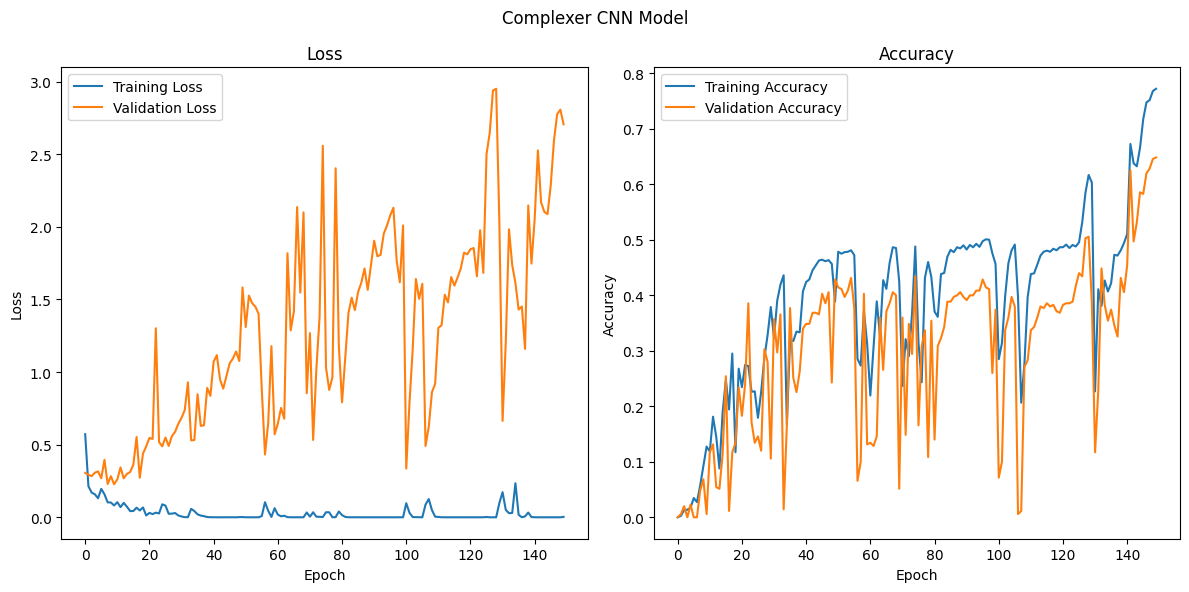

In [ ]:
#Retrieve the training and validation loss
train_loss=history4.history['loss']
val_loss=history4.history['val_loss']

#Retrieve the training and validation accuracy
train_acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

fig5, axs = plt.subplots(1, 2, figsize=(12, 6))

#Plot training and validation loss
axs[0].plot(train_loss, label='Training Loss')
axs[0].plot(val_loss, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss')
axs[0].legend()

#Plot training and validation accuracy
axs[1].plot(train_acc, label='Training Accuracy')
axs[1].plot(val_acc, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy')
axs[1].legend()

fig5.suptitle('Deeper 3 Convolutional Pais CNN Model')
plt.tight_layout()
plt.show()

15/15 [==============================] - 7s 439ms/step
Confusion Matrix:
[[91 98]
 [87 96]]


<function matplotlib.pyplot.show(close=None, block=None)>

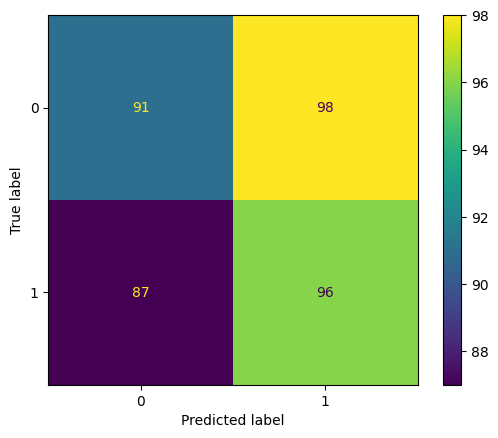

In [ ]:
#Generate predictions on validation data
y_pred_prob = model4.predict(validation_generator2)

#Convert probabilities to binary predictions
y_pred = np.round(y_pred_prob)

#Extract true labels from the generator
true_labels = validation_generator2.classes

#Construct confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred)

#Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

cm_display = ConfusionMatrixDisplay(conf_matrix)
cm_display.plot()
plt.show

This architecture improved the result slightly. The model was able to get over 60% for a period, but the end result was still not very good. The model fluctuated greatly in training, suggesting that there could be some vanishing gradient issue.  
We found it interesting that once the model broke the 50% barrier, it appeared to be able to increase accuracy more quickly. This observation makes sense as once the model is able to get more correct than not, it can make more informed back propogation and successfully improve itself more quickly.

## Model 4 w/ Skip Level Connections

So far Model 4 performs the best, but spikes on the accuracy and loss plots suggested possible issues with gradient loss during learning.

Skip layers apply an identity function to preserve data across convolutions through deep training. On the convolution layers, we simply add the output of the last activation to the output of the convolution.

We must separate the activation step from the Conv2D to insert the skip layers appropriately. Using Resnet v1 style:

* Conv2D
* Relu
* Conv2D
* Add
* Relu
* ... repeat
* ... end on relu before dense layers


Parameters: 127 million  
8x the base model

In [ ]:
def skip_level_block(units, x):
  # units = the number of neurons you want in the layer
  # x = the input from the last layer, assumed to be maxpooling
  # padding and strides ensures common shape for the adding step.

  #identity
  x1 = Conv2D(filters = units, kernel_size=(3, 3), strides = (1, 1), padding="same")(x)

  # addition
  # x2 = BatchNormalization()(x1)
  x2 = ReLU()(x1)
  x2 = Conv2D(filters = units, kernel_size=(3, 3), strides = (1, 1), padding="same")(x2)
  # x2 = BatchNormalization()(x2)
  x2 = Add()([x1, x2])
  x2 = ReLU()(x2)

  return x2

# initial layers
inputs = tf.keras.Input(shape=(image_height, image_width, 3))
x = layers.Conv2D(32, kernel_size=(3, 3), strides = (1, 1), padding="same", activation='relu')(inputs)
x = layers.Conv2D(64, kernel_size=(3, 3), strides = (1, 1), padding="same", activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# 128 skip level block
x = skip_level_block(128,x)
x = layers.MaxPooling2D((2, 2))(x)

# 256 skip level block
x = skip_level_block(256,x)
x = layers.MaxPooling2D((2, 2))(x)

# classification
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model4_with_skips = tf.keras.Model(inputs, outputs)
model4_with_skips.compile(optimizer='adam', loss=BinaryCrossentropy(),
                          metrics=[keras.metrics.Accuracy(),
                                   tf.keras.metrics.Precision(name='precision'),
                                   tf.keras.metrics.Recall(name='recall')])

In [ ]:
model4_with_skips.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 250, 250, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 250, 250, 32)         896       ['input_3[0][0]']             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 250, 250, 64)         18496     ['conv2d_6[0][0]']            
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 125, 125, 64)         0         ['conv2d_7[0][0]']            
 g2D)                                                                                         

In [ ]:
#Train the deeper model

history4_with_skips = model4_with_skips.fit(
    train_generator2,
    steps_per_epoch=train_generator2.samples // small_batch_size,
    epochs=50,
    validation_data=validation_generator2,
    validation_steps=validation_generator2.samples // small_batch_size,
)

Epoch 1/50
60/60 [==============================] - 762s 12s/step - loss: 0.5953 - accuracy: 0.0054 - precision: 0.7931 - recall: 0.8625 - val_loss: 0.3135 - val_accuracy: 0.0000e+00 - val_precision: 0.8028 - val_recall: 0.9828
Epoch 2/50
60/60 [==============================] - 12s 191ms/step - loss: 0.1849 - accuracy: 0.0107 - precision: 0.9309 - recall: 0.9577 - val_loss: 0.2457 - val_accuracy: 0.0000e+00 - val_precision: 0.9484 - val_recall: 0.8802
Epoch 3/50
60/60 [==============================] - 12s 190ms/step - loss: 0.1538 - accuracy: 0.0122 - precision: 0.9498 - recall: 0.9511 - val_loss: 0.3046 - val_accuracy: 0.0200 - val_precision: 0.8342 - val_recall: 0.9471
Epoch 4/50
60/60 [==============================] - 11s 188ms/step - loss: 0.1179 - accuracy: 0.0217 - precision: 0.9637 - recall: 0.9597 - val_loss: 0.2166 - val_accuracy: 0.0000e+00 - val_precision: 0.9571 - val_recall: 0.9231
Epoch 5/50
60/60 [==============================] - 11s 187ms/step - loss: 0.1622 - accur

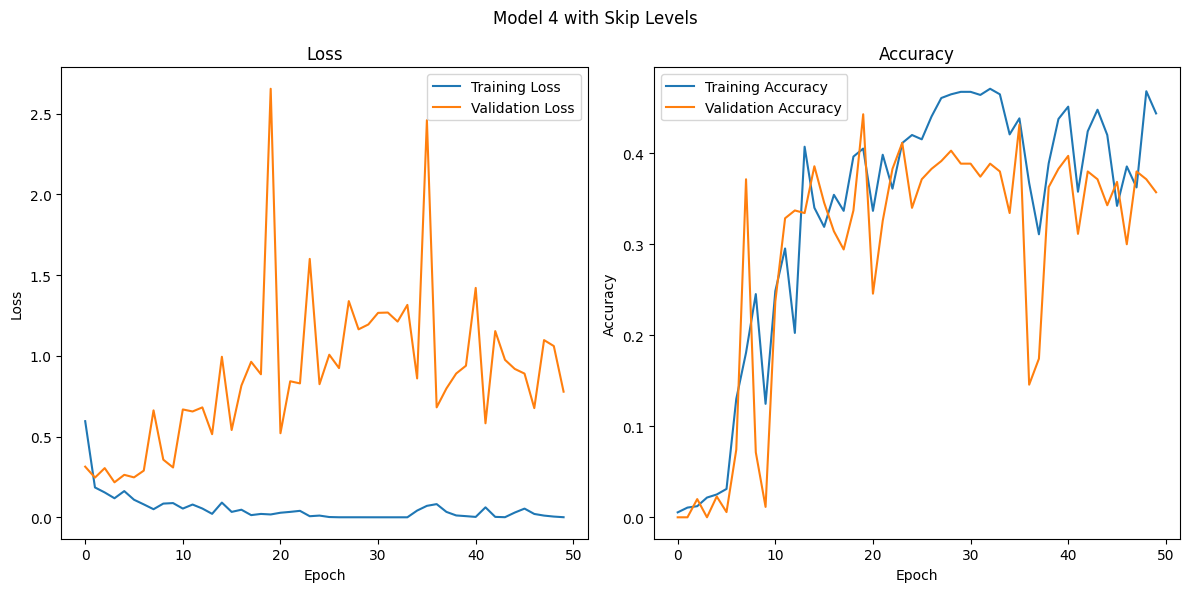

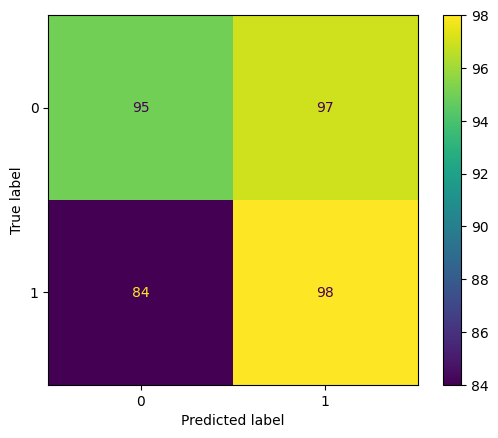

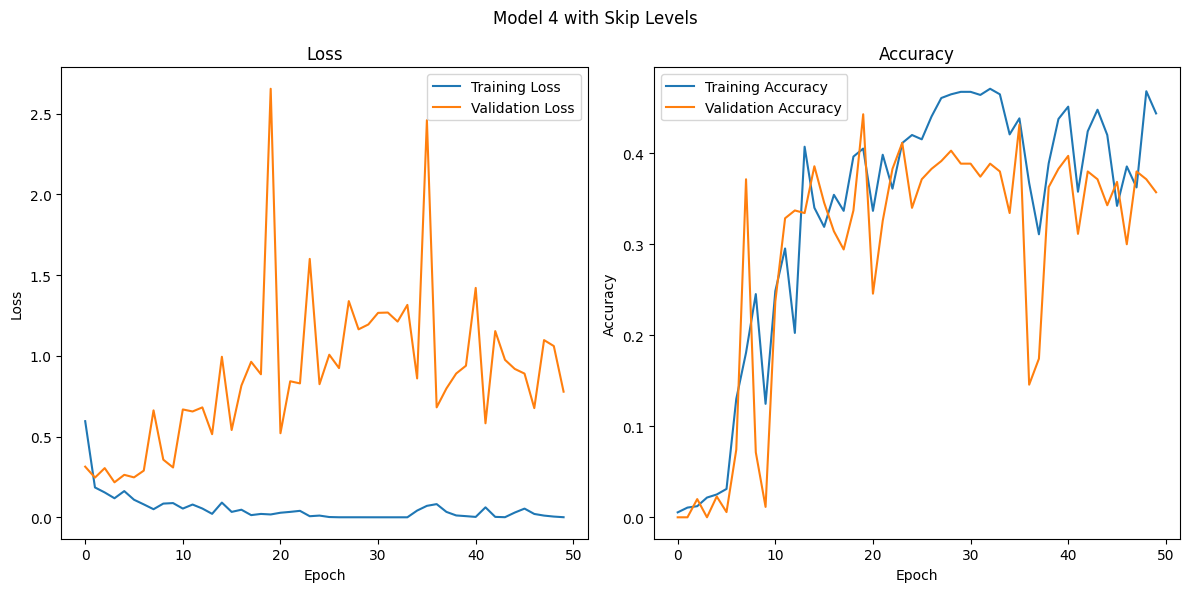

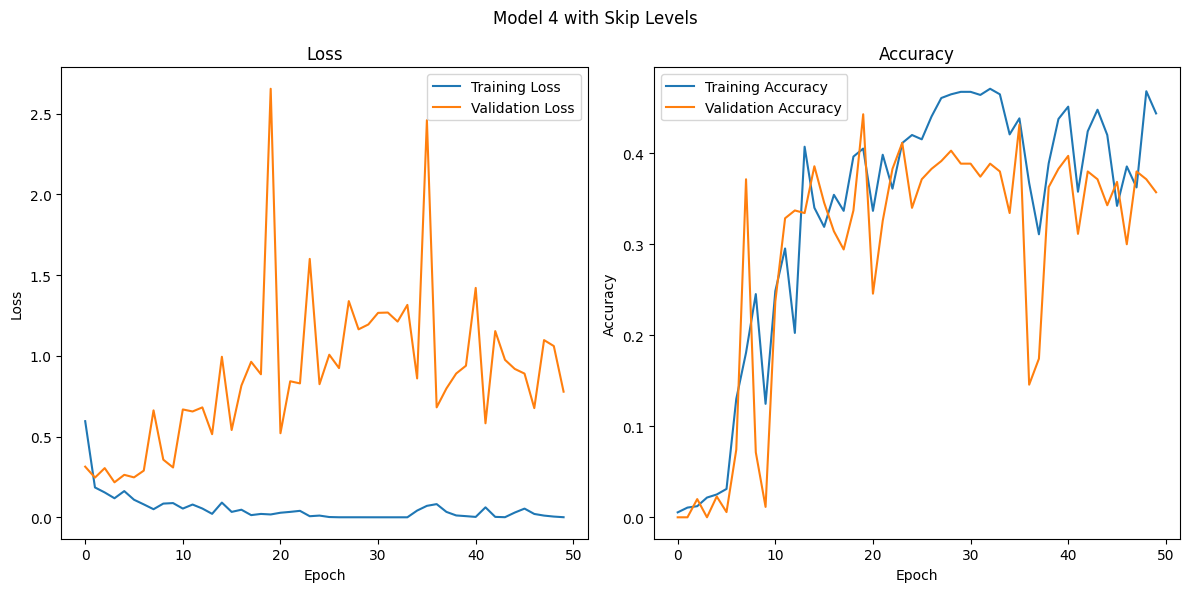

In [ ]:
%matplotlib inline
#Retrieve the training and validation loss
train_loss=history4_with_skips.history['loss']
val_loss=history4_with_skips.history['val_loss']

#Retrieve the training and validation accuracy
train_acc = history4_with_skips.history['accuracy']
val_acc = history4_with_skips.history['val_accuracy']

fig5, axs = plt.subplots(1, 2, figsize=(12, 6))

#Plot training and validation loss
axs[0].plot(train_loss, label='Training Loss')
axs[0].plot(val_loss, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss')
axs[0].legend()

#Plot training and validation accuracy
axs[1].plot(train_acc, label='Training Accuracy')
axs[1].plot(val_acc, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy')
axs[1].legend()

fig5.suptitle('Model 4 with Skip Levels')
plt.tight_layout()
plt.show()

In [ ]:
#Generate predictions on validation data
y_pred_prob = model4_with_skips.predict(validation_generator2)

#Convert probabilities to binary predictions
y_pred = np.round(y_pred_prob)

#Extract true labels from the generator
true_labels = validation_generator2.classes

#Construct confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred)

#Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

cm_display = ConfusionMatrixDisplay(conf_matrix)
cm_display.plot()
plt.show

15/15 [==============================] - 6s 443ms/step
Confusion Matrix:
[[95 97]
 [84 98]]


<function matplotlib.pyplot.show(*, block=None)>

Here we can see the use of the skip layers did not help to improve the model. It did limit the spikes in accuracy, but did not remove them. This indicates the fluctuations may be more due to the dropout than a vanishing gradient.

## Model Iteration #5
Increase the capacity of the model, aiming to 10x the parameters in the single layer model.  
Previously, we have increased the number of filters in the layers to alow the model to contruct more features. Now, we are also going to implement larger kernal sizes at the first two layers to allow the model to construct more broad features to learn from. In the first convolutional layer we increased the kernal size from 3x3 to 7x7. In the second layer increased from 3x3 to 5x5. Increasing the size of kernals at the first level and then decreasing ing subsequent layers is a common technique used to gain more features in the model at the smallest granularity. Additionally, we will increase the kernal size in one of the convolutional layers in the second and third convolutional pairs. However, as we go deeper, we will the size of the kernals, thus allowing the model to construct the larger or more broad features in the images. We will also increase neurons in first dense layer to 1024, this will provide the model with nearl double the number of parameters as we had in Model 4.  
Another change we made in this iteration is to replace the optimizer Adam with RMSProp. We chose this because of the continued observation of the training loss function to quickly approach zero while there remains more room to improve accuracy. Using RMSProp will reduce the impact of momentum on the learning rate and we hope it will allow the model to continue to improve for a longer period of epochs while also increasing the speed of training by not having to compute the running average calculation for the momentum component of Adam optimization.  
Parameters: 167 million  
10.5x over base model

### Model 5 Base
With no dropout and RMSProp optimizer. RMSProp was chosen to speed up the training and reduce the impact of momentum on the learning rate. A training of 50 epochs to evaluate viability.

In [ ]:
#Again, creating a small batch size to train with for this model.
#Image Directory
image_folder='/content/gdrive/My Drive/forest_fire/Training_and_Validation'

#ImageDataGenerator to scale images and then split into training and validation sets
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)

#Set image specifications
image_height=250
image_width=250

#Reduce the batch size for larger model
smallest_batch_size=10

#Load and split the data
train_generator3=datagen.flow_from_directory(
        image_folder,
        target_size=(image_height, image_width),
        batch_size=smallest_batch_size,
        class_mode='binary',
        subset='training')

validation_generator3=datagen.flow_from_directory(
        image_folder,
        target_size=(image_height, image_width),
        batch_size=smallest_batch_size,
        class_mode='binary',
        subset='validation')

Found 1501 images belonging to 2 classes.
Found 374 images belonging to 2 classes.


In [ ]:
#Increase capacity 10x
#Imeplment larger kernal sizes to allow for more broad feature themes to be learned

model5 = models.Sequential([
    layers.Conv2D(32, (7, 7), activation='relu', input_shape=(image_height, image_width, 3)),
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Conv2D(256, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with weighted binary cross-entropy loss
model5.compile(optimizer='rmsprop', loss=BinaryCrossentropy() , metrics=[keras.metrics.Accuracy()])

In [ ]:
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 244, 244, 32)      4736      
                                                                 
 conv2d_31 (Conv2D)          (None, 240, 240, 64)      51264     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 120, 120, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 118, 118, 128)     73856     
                                                                 
 conv2d_33 (Conv2D)          (None, 114, 114, 128)     409728    
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 57, 57, 128)       0         
 ng2D)                                                

In [ ]:
checkpoint_path = "/content/gdrive/My Drive/forest_fire/checkpoint/model5_parameters_epoch.weights.h5"

#Callback checkpoint to save model parameters at each epoch
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_accuracy',
                                      save_weights_only=True,
                                      save_best_only=False,
                                      save_freq='epoch',
                                      verbose=1)


In [ ]:
#Train the XL model

history5= model5.fit(
    train_generator3,
    steps_per_epoch=train_generator3.samples // smallest_batch_size,
    epochs=50,
    validation_data=validation_generator3,
    validation_steps=validation_generator3.samples // smallest_batch_size,
    callbacks=[checkpoint_callback]
)

Epoch 1/50
149/149 [==============================] - ETA: 0s - loss: 0.7609 - accuracy: 0.0088
Epoch 1: saving model to model5_parameters_epoch5.h5
149/149 [==============================] - 24s 125ms/step - loss: 0.7609 - accuracy: 0.0088 - val_loss: 0.4834 - val_accuracy: 0.0000e+00
Epoch 2/50
149/149 [==============================] - ETA: 0s - loss: 0.4605 - accuracy: 0.0074
Epoch 2: saving model to model5_parameters_epoch5.h5
149/149 [==============================] - 16s 103ms/step - loss: 0.4605 - accuracy: 0.0074 - val_loss: 0.3521 - val_accuracy: 0.0000e+00
Epoch 3/50
149/149 [==============================] - ETA: 0s - loss: 0.3487 - accuracy: 0.0047
Epoch 3: saving model to model5_parameters_epoch5.h5
149/149 [==============================] - 17s 113ms/step - loss: 0.3487 - accuracy: 0.0047 - val_loss: 0.7201 - val_accuracy: 0.0324
Epoch 4/50
149/149 [==============================] - ETA: 0s - loss: 0.3434 - accuracy: 0.0148
Epoch 4: saving model to model5_parameters_epoc

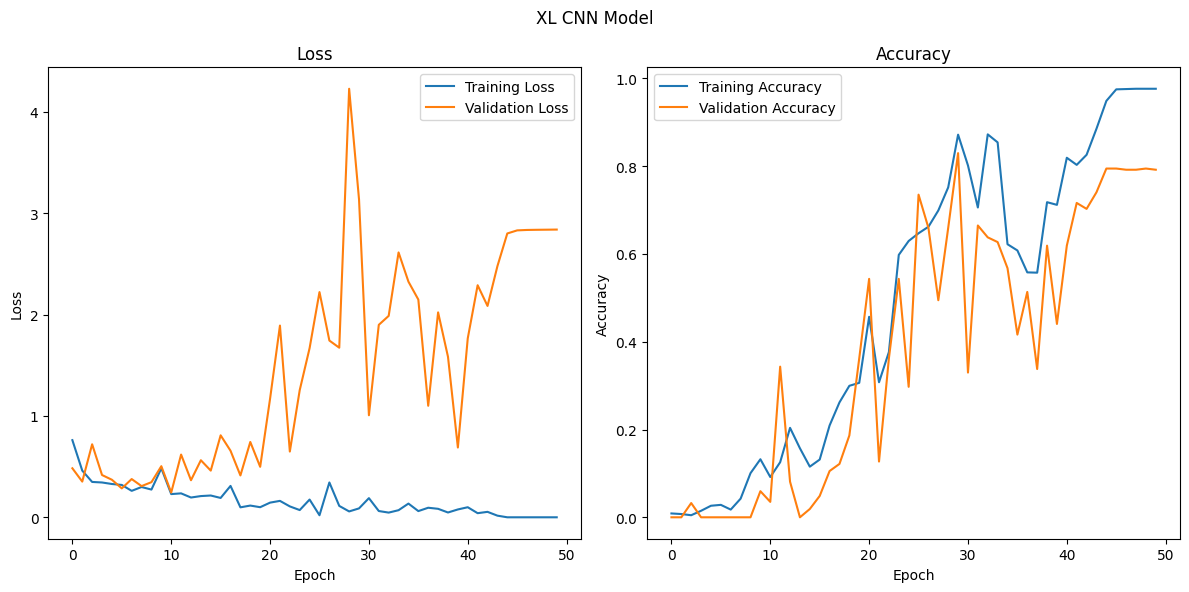

In [ ]:
#Retrieve the training and validation loss
train_loss=history5.history['loss']
val_loss=history5.history['val_loss']

#Retrieve the training and validation accuracy
train_acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

fig7, axs = plt.subplots(1, 2, figsize=(12, 6))

#Plot training and validation loss
axs[0].plot(train_loss, label='Training Loss')
axs[0].plot(val_loss, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss')
axs[0].legend()

#Plot training and validation accuracy
axs[1].plot(train_acc, label='Training Accuracy')
axs[1].plot(val_acc, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy')
axs[1].legend()

fig7.suptitle('XL CNN Model')
plt.tight_layout()
plt.show()

The initial 50 epochs prove promising, with the model reaching near 100% on the training data and 80% on validation. As the model may have been continuing to learn, increase the epochs to 100 to see if the accuarcy on validation data can improve farther.

In [ ]:
#Train the XL model

history5_base= model5.fit(
    train_generator3,
    steps_per_epoch=train_generator3.samples // smallest_batch_size,
    epochs=100,
    validation_data=validation_generator3,
    validation_steps=validation_generator3.samples // smallest_batch_size,
    callbacks=[checkpoint_callback]
)

Epoch 1/100
149/149 [==============================] - ETA: 0s - loss: 1.0453 - accuracy: 0.0081
Epoch 1: saving model to /content/gdrive/My Drive/forest_fire/checkpoint/model_parameters_epoch.weights.h5
149/149 [==============================] - 526s 3s/step - loss: 1.0453 - accuracy: 0.0081 - val_loss: 0.4736 - val_accuracy: 0.0000e+00
Epoch 2/100
149/149 [==============================] - ETA: 0s - loss: 0.4499 - accuracy: 0.0047
Epoch 2: saving model to /content/gdrive/My Drive/forest_fire/checkpoint/model_parameters_epoch.weights.h5
149/149 [==============================] - 39s 258ms/step - loss: 0.4499 - accuracy: 0.0047 - val_loss: 0.3876 - val_accuracy: 0.0000e+00
Epoch 3/100
149/149 [==============================] - ETA: 0s - loss: 0.3476 - accuracy: 0.0074
Epoch 3: saving model to /content/gdrive/My Drive/forest_fire/checkpoint/model_parameters_epoch.weights.h5
149/149 [==============================] - 32s 213ms/step - loss: 0.3476 - accuracy: 0.0074 - val_loss: 0.3807 - v

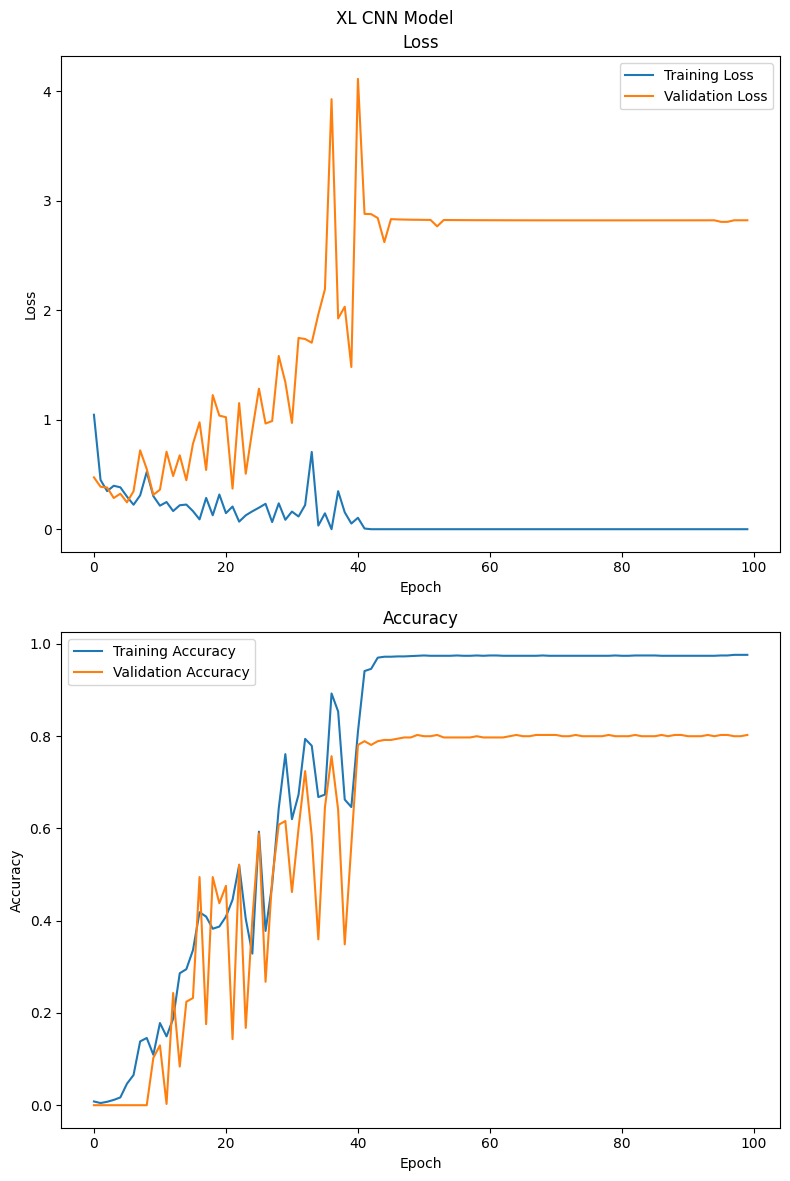

In [ ]:
#Retrieve the training and validation loss
train_loss=history5_base.history['loss']
val_loss=history5_base.history['val_loss']

#Retrieve the training and validation accuracy
train_acc = history5_base.history['accuracy']
val_acc = history5_base.history['val_accuracy']

fig7, axs = plt.subplots(2, 1, figsize=(8, 12))

#Plot training and validation loss
axs[0].plot(train_loss, label='Training Loss')
axs[0].plot(val_loss, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss')
axs[0].legend()

#Plot training and validation accuracy
axs[1].plot(train_acc, label='Training Accuracy')
axs[1].plot(val_acc, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy')
axs[1].legend()

fig7.suptitle('XL CNN Model')
plt.tight_layout()
plt.show()

Turns out the model did plateau after 50 epochs. The loss diminshed to negligible values and the model could not learn further. However, this is a vast improvement over the previous iterations. Achieiving near perfect accuracy on the training data, the model was able to learn the nuance and complexity of the images quite well. The accuarcy on the validation data pleateued at 80%. We will implement some regularization techiniques to try to prevent any overfitting to the training data and increase the generalizability to the validation and unseen images.

In [ ]:
#Save model
model5.save('/content/gdrive/My Drive/forest_fire/model5.keras')


### Model 5 w/ Regularization
Implement L2 regularization on the model in the dense layers to prevent overfitting and improve the performance on validation images.

In [ ]:
#With model 5, add regularization to prevent overfitting

model5_L2 = models.Sequential([
    layers.Conv2D(32, (7, 7), activation='relu', input_shape=(image_height, image_width, 3)),
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Conv2D(256, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with weighted binary cross-entropy loss
model5_L2.compile(optimizer='rmsprop', loss=BinaryCrossentropy() , metrics=[keras.metrics.Accuracy()])

In [ ]:
model5_L2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 244, 244, 32)      4736      
                                                                 
 conv2d_7 (Conv2D)           (None, 240, 240, 64)      51264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 120, 120, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 118, 118, 128)     73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 114, 114, 128)     409728    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 57, 57, 128)       0         
 g2D)                                                   

In [ ]:
#Train the XL model with L2 regularizer

history5_3= model5_L2.fit(
    train_generator3,
    steps_per_epoch=train_generator3.samples // smallest_batch_size,
    epochs=100,
    validation_data=validation_generator3,
    validation_steps=validation_generator3.samples // smallest_batch_size,
    callbacks=[checkpoint_callback]
)

Epoch 1/100
150/150 [==============================] - ETA: 0s - loss: 4.3286 - accuracy: 0.0195
Epoch 1: saving model to /content/gdrive/My Drive/forest_fire/checkpoint/model5_parameters_epoch.weights.h5
150/150 [==============================] - 34s 145ms/step - loss: 4.3286 - accuracy: 0.0195 - val_loss: 0.7753 - val_accuracy: 0.0000e+00
Epoch 2/100
150/150 [==============================] - ETA: 0s - loss: 0.4925 - accuracy: 0.0074
Epoch 2: saving model to /content/gdrive/My Drive/forest_fire/checkpoint/model5_parameters_epoch.weights.h5
150/150 [==============================] - 23s 154ms/step - loss: 0.4925 - accuracy: 0.0074 - val_loss: 0.3227 - val_accuracy: 0.0000e+00
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 0.4114 - accuracy: 0.0087
Epoch 3: saving model to /content/gdrive/My Drive/forest_fire/checkpoint/model5_parameters_epoch.weights.h5
150/150 [==============================] - 22s 137ms/step - loss: 0.4114 - accuracy: 0.0087 - val_loss: 0.338

This regularization was wholely unsuccessful. The model failed to reach even 50% accuracy on the training data

### Model 5 with Adam
Changing the optimization to Adam to see if the momentum component of the learning rate will help to improve the result.

In [ ]:
#Change optimizer to Adam to see if the momentum component of the learning rate will help.

model5_adam = models.Sequential([
    layers.Conv2D(32, (7, 7), activation='relu', input_shape=(image_height, image_width, 3)),
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Conv2D(256, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    # layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    # layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with weighted binary cross-entropy loss
model5_adam.compile(optimizer='adam', loss=BinaryCrossentropy() , metrics=[keras.metrics.Accuracy()])

In [ ]:
#Train the XL model with Adam

history5_4= model5_adam.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // smallest_batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // smallest_batch_size,
    callbacks=[checkpoint_callback]
)

Epoch 1/100
30/30 [==============================] - ETA: 0s - loss: 2.0860 - accuracy: 0.0200
Epoch 1: saving model to /content/gdrive/My Drive/forest_fire/checkpoint/model5_parameters_epoch.weights.h5
30/30 [==============================] - 57s 915ms/step - loss: 2.0860 - accuracy: 0.0200 - val_loss: 0.5035 - val_accuracy: 0.0000e+00
Epoch 2/100
30/30 [==============================] - ETA: 0s - loss: 0.2566 - accuracy: 0.0000e+00
Epoch 2: saving model to /content/gdrive/My Drive/forest_fire/checkpoint/model5_parameters_epoch.weights.h5
30/30 [==============================] - 17s 549ms/step - loss: 0.2566 - accuracy: 0.0000e+00 - val_loss: 0.2264 - val_accuracy: 0.0000e+00
Epoch 3/100
30/30 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.0573
Epoch 3: saving model to /content/gdrive/My Drive/forest_fire/checkpoint/model5_parameters_epoch.weights.h5
30/30 [==============================] - 19s 561ms/step - loss: 0.1597 - accuracy: 0.0573 - val_loss: 0.8753 - 

Using Adam as the optimizer in the model was completely unsuccessful. The model failed to reach even 20% on the validation data. This supports our decision to use the RMSProp optimizer.

### Model 5 w/ Dropout
Attempting to add dropout into the model to prevent the overfitting to the training data. Returning to the RMSProp optimizer from the model 5 base.

In [ ]:
#Implement dropout in the dense layers to prevent overfitting and allow for better generalization to unseen images

model5_dropout = models.Sequential([
    layers.Conv2D(32, (7, 7), activation='relu', input_shape=(image_height, image_width, 3)),
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Conv2D(256, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with weighted binary cross-entropy loss
model5_dropout.compile(optimizer='rmsprop', loss=BinaryCrossentropy() , metrics=[keras.metrics.Accuracy()])

In [ ]:
model5_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 244, 244, 32)      4736      
                                                                 
 conv2d_7 (Conv2D)           (None, 240, 240, 64)      51264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 120, 120, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 118, 118, 128)     73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 114, 114, 128)     409728    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 57, 57, 128)       0         
 g2D)                                                 

In [ ]:
checkpoint_path_dropout = "/content/gdrive/My Drive/forest_fire/checkpoint/model5_dropout_parameters_epoch.weights.h5"

#Callback checkpoint to save model parameters at each epoch
checkpoint_callback_dropout = ModelCheckpoint(filepath=checkpoint_path_dropout,
                                      monitor='val_accuracy',
                                      save_weights_only=True,
                                      save_best_only=False,
                                      save_freq='epoch',
                                      verbose=1)

In [ ]:
#Train the XL model with dropout to improve generalizability

history5_dropout= model5_dropout.fit(
    train_generator3,
    steps_per_epoch=train_generator3.samples // smallest_batch_size,
    epochs=100,
    validation_data=validation_generator3,
    validation_steps=validation_generator3.samples // smallest_batch_size,
    callbacks=[checkpoint_callback_dropout]
)

Epoch 1/100
149/149 [==============================] - ETA: 0s - loss: 2.3529 - accuracy: 0.0128
Epoch 1: saving model to /content/gdrive/My Drive/forest_fire/checkpoint/model_parameters_epoch.weights.h5
149/149 [==============================] - 51s 328ms/step - loss: 2.3529 - accuracy: 0.0128 - val_loss: 2.9949 - val_accuracy: 0.0000e+00
Epoch 2/100
149/149 [==============================] - ETA: 0s - loss: 0.7240 - accuracy: 0.0223
Epoch 2: saving model to /content/gdrive/My Drive/forest_fire/checkpoint/model_parameters_epoch.weights.h5
149/149 [==============================] - 34s 227ms/step - loss: 0.7240 - accuracy: 0.0223 - val_loss: 0.6721 - val_accuracy: 0.0000e+00
Epoch 3/100
149/149 [==============================] - ETA: 0s - loss: 0.8446 - accuracy: 0.0101
Epoch 3: saving model to /content/gdrive/My Drive/forest_fire/checkpoint/model_parameters_epoch.weights.h5
149/149 [==============================] - 35s 234ms/step - loss: 0.8446 - accuracy: 0.0101 - val_loss: 0.5638 -

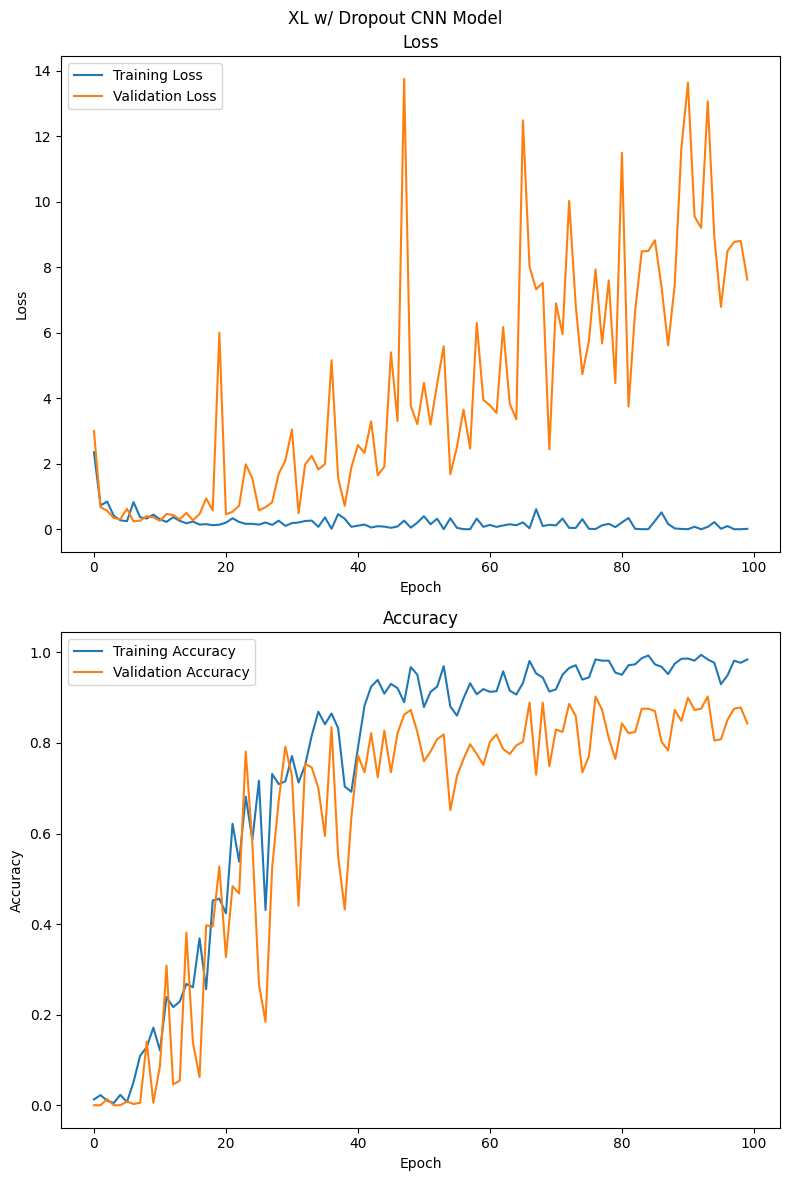

In [ ]:
#Retrieve the training and validation loss
train_loss=history5_dropout.history['loss']
val_loss=history5_dropout.history['val_loss']

#Retrieve the training and validation accuracy
train_acc = history5_dropout.history['accuracy']
val_acc = history5_dropout.history['val_accuracy']

fig9, axs = plt.subplots(2, 1, figsize=(8, 12))

#Plot training and validation loss
axs[0].plot(train_loss, label='Training Loss')
axs[0].plot(val_loss, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss')
axs[0].legend()

#Plot training and validation accuracy
axs[1].plot(train_acc, label='Training Accuracy')
axs[1].plot(val_acc, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy')
axs[1].legend()

fig9.suptitle('XL w/ Dropout CNN Model')
plt.tight_layout()
plt.show()

In [ ]:
#Save model, if desired
#model5_dropout.save('/content/gdrive/My Drive/forest_fire/model5_dropout.keras')


Adding the dropout into the dense layers of this model helped to generalize the model and improve the accuracy on the validation data. The dropout prevented the model from overfitting to the training data.  
While the training accuracy began to plateau at 50 epochs, like without dropout, the model continued to improve accuracy slowly on the vlaidation data over epochs 50-100. The model continued to improve by not relying on creating specific pathways but creating more general paths , because of the dropout, allowing it to improve on unseen images.  
The model approached 98% accuracy on the training data and above 80% on the validation images. This is a significant improvement over the previous iterations.

## Evaluation of the Best Model
Model 5 with dropout has performed the best on the training and validation sets. We will now evaluate this model, making predictions on the unseen test images to determine how it performs and if it achieves our goal.
Stated goals:
- Exceed accuracy of XGBoost model of 77% on predictions on unseen images.
- Obtain maximum accuracy nearing 99% from ResNet using a less complex model.

In [10]:
#Load saved model, if needed from our pretrained version
best_model=keras.models.load_model('/content/gdrive/My Drive/forest_fire/model5_dropout.keras')

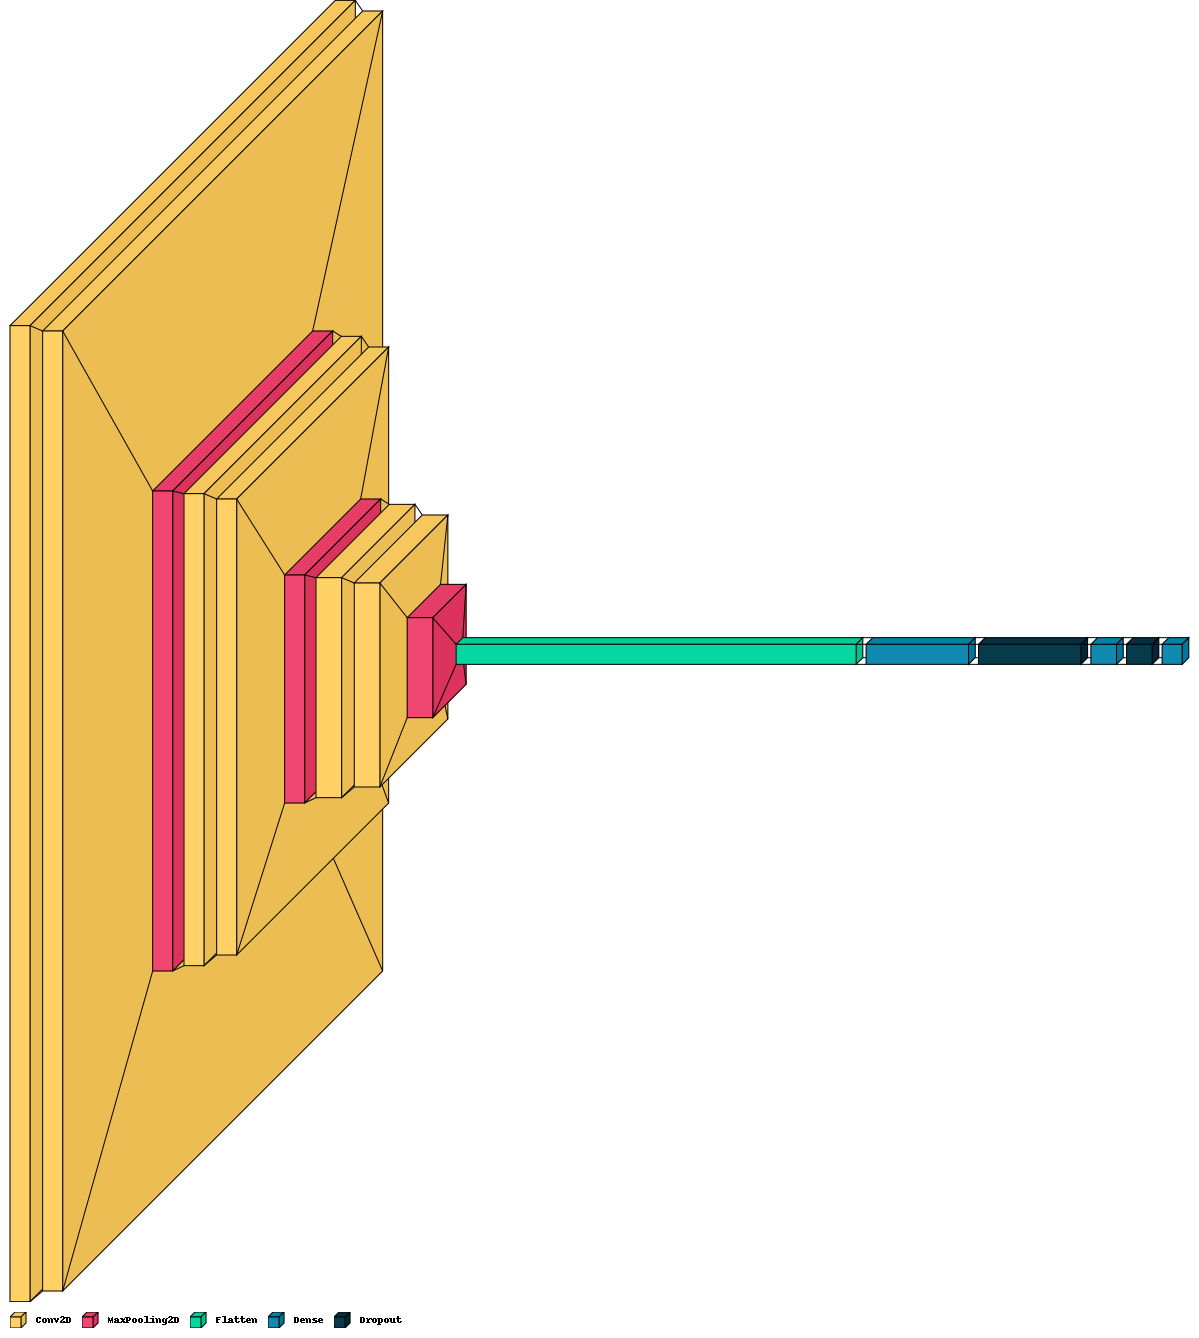

In [11]:
visualkeras.layered_view(best_model, legend=True)

Load the testing images which have been held out and unused to this point.

In [ ]:
#Create list of directories to search for test images
test_nofire_dir = '/content/gdrive/My Drive/forest_fire/Testing/nofire'
test_fire_dir = '/content/gdrive/My Drive/forest_fire/Testing/fire'
test_dir=[test_nofire_dir,test_fire_dir]

#Lists to hold test images and the associated labels
testing_images = []
testing_labels = []

#For loop to iterate through the diretories
for dir in test_dir:
    for img_name in os.listdir(dir):
        img_path = os.path.join(dir, img_name)

        #Load image
        img = Image.open(img_path)

        #Ensure image is sized properly
        img = img.resize((250, 250))

        #Convert image to numpy array and scale
        img_array = np.array(img)
        img_array = img_array / 255.0

        #Append the image and its label to the lists
        testing_images.append(img_array)

        #Assign label based on directory name
        if dir.endswith('nofire'):
            testing_labels.append(1) #No fire is labeled as 1 due to directory file structure in training images
        else:
            testing_labels.append(0) #Fire labeled as 0

#Convert lists to numpy arrays
testing_images = np.array(testing_images)
testing_labels = np.array(testing_labels)


### Confusion Matrix
Construct a confusion matrix to visualize the model predictions.

3/3 [==============================] - 0s 124ms/step


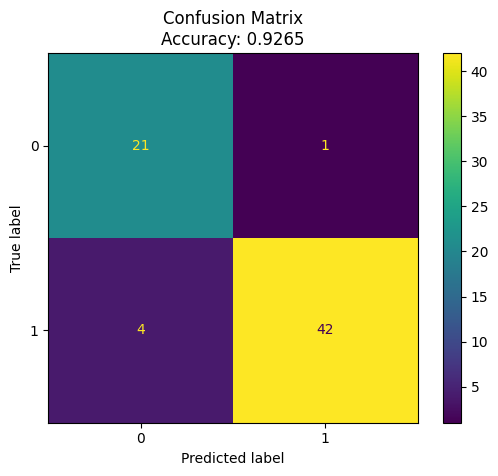

In [ ]:
#Generate predictions on test images
y_pred_prob = best_model.predict(testing_images)

#Convert probabilities predictions
y_pred = np.round(y_pred_prob)

#Construct and display confusion matrix
conf_matrix = confusion_matrix(testing_labels, y_pred)
cm_display = ConfusionMatrixDisplay(conf_matrix)
cm_display.plot()
plt.title(f'Confusion Matrix\nAccuracy: {round(accuracy_score(testing_labels, y_pred),4)}')
plt.show()

The model was able to predict on the 68 unseen test images with an accuracy of 92.7%. There were 5 misclassifications on this test data. We will investigate those images further.

### ROC Area Under the Curve

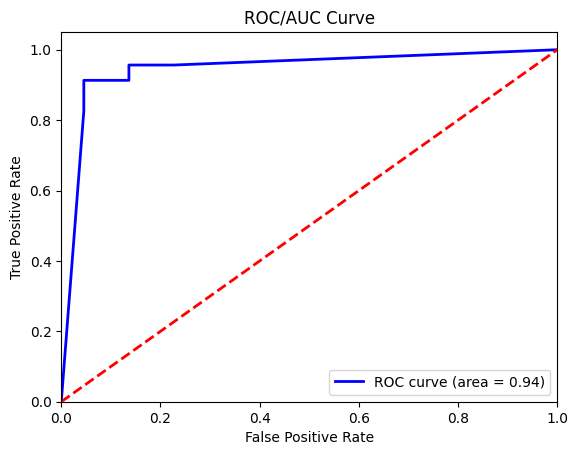

In [ ]:
#Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(testing_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

#Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC/AUC Curve')
plt.legend()
plt.show()

### Test Results
The model demonstrates excellent performance, as indicated by the ROC area under the curve score of 0.95. This high AUC value indicates that the model has a strong ability to distinguish between the fire and no fire classes, achieving a high level of accuracy in its predictions.  
With an accuracy of 92.7%, the model successfully out performs our XGBoost model baseline of 77%. While the model's accuracy does not quite perform as well as the 99% achieved by the ResNet implementation, its effectiveness in correctly classifying instances of both classes makes it a reliable tool.

### Investigate Error
As shown above in the confusion matrix, the model incorrectly predicted 5 of the test images. In order to determine potential next steps to further improve the model,  we want to display these incorrectly predicted images. We will investigate these images and determine if there are commonalities.

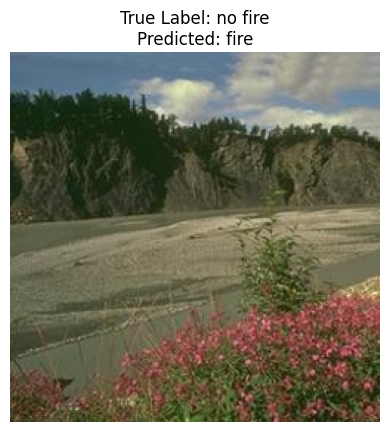

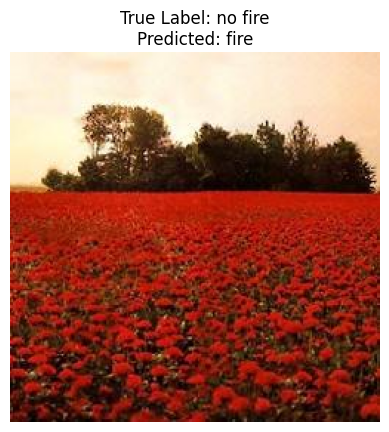

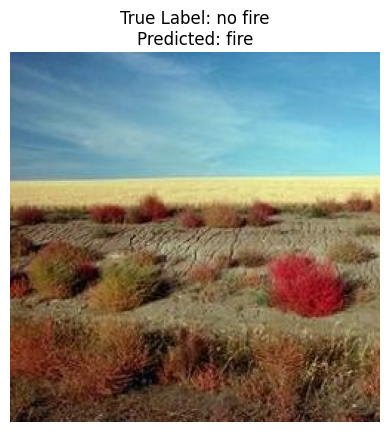

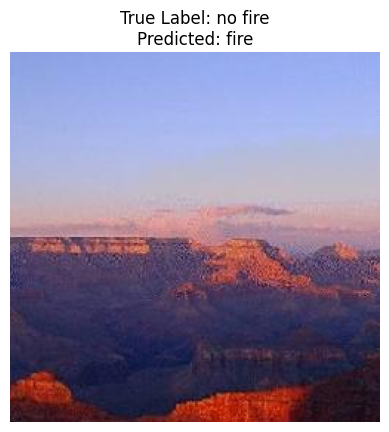

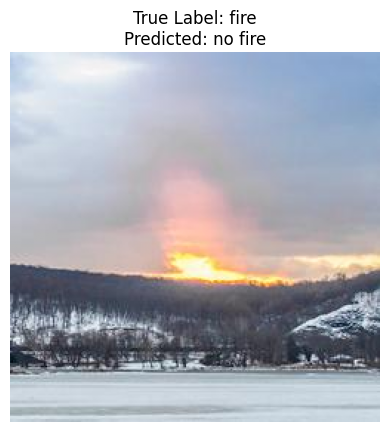

In [ ]:
#Retrieve and display the incorrectly predicted images
labels=['fire','no fire']
errors=[]
for i in range(len(testing_labels)):
  if testing_labels[i]!=y_pred[i]:
    errors.append(i)
    #Display the image and the true and predicted labels
    plt.imshow(testing_images[i])
    plt.axis('off')
    plt.title(f'True Label: {labels[testing_labels[i]]}\nPredicted: {labels[int(y_pred[i][0])]}')
    plt.show()

These are the test images which were classified incorrectly by the model. 4 have the true label of no fire and 1 has the true label of fire. The 4 images with no fire all have patches of orange, red, or pink in concentrated in the images, 3 of which are plants or flowers. The model may be construing these patches of red, pink and orange to resemble fire in other trained images.  
The one image which does contain fire and was classified incorrectly is a landscape photo of fire on top of a distant hill or mountain. While this is an image of fire, even to the human eye it could easily be interpreted as a sunrise or sunset over a mountain.  
To remedy these errors, we could seek additional images of plants or flowers in the red and orange hue classified as no fire and provide them to the model for further training to potentially learn more of the nuance between flowers of these colors and fire.  
Another option would be to perform image augmentation on both the fire and not fire images. As noted in the data exploration, fire images tended to have more red toward the bottom half of the image, while not fire images had more green and blue at the top of the image. By rotating the images, we might break the model’s reliance upon these distinctions of sky and horizon and of fire rising through the image. This may make the model less reliant upon the location of color in the images and make it more robust to different orientations as well.
